In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f897c363b80>,)

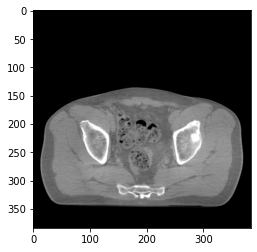

In [29]:
plt.imshow(x.squeeze(), 'gray'),

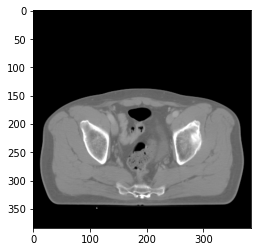

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [33]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [34]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [35]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [36]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=20, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=20, T_mult=2)

In [39]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [40]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:44,  1.91it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.53it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.53it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.54it/s]
84it [00:41,  2.04it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.54it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.53it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.55it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.53it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.07s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.54it/s]
84it [00:41,  2.03it/s]
84it [01:29,  1.

In [41]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [42]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [43]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8459344506263733
psnr score = 24.992778778076172
snr score = 15.055715560913086
mae error = 0.019028060138225555
air dice score = 0.9961954070326173
bone dice score = 0.9280291527493466
contour dice score = 0.690887451171875


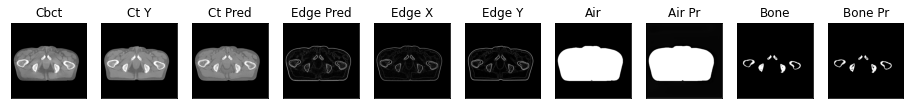

1it [00:00,  2.10it/s]

ssim score = 0.8459894061088562
psnr score = 24.93997573852539
snr score = 15.05044937133789
mae error = 0.019276391714811325
air dice score = 0.9961886285921479
bone dice score = 0.921304018196796
contour dice score = 0.7232516407966614


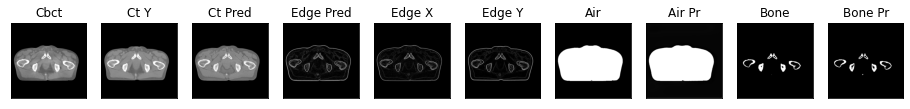

2it [00:00,  2.25it/s]

ssim score = 0.8442382216453552
psnr score = 24.670583724975586
snr score = 14.943953514099121
mae error = 0.02073061466217041
air dice score = 0.996147776394597
bone dice score = 0.9040489519606295
contour dice score = 0.7209580540657043


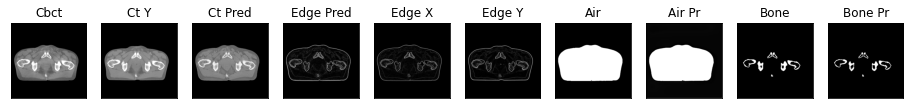

3it [00:01,  2.02it/s]

ssim score = 0.8403903841972351
psnr score = 24.599533081054688
snr score = 14.962157249450684
mae error = 0.021303735673427582
air dice score = 0.9962082514734811
bone dice score = 0.8811338732744027
contour dice score = 0.6870503425598145


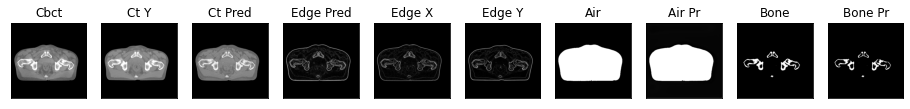

4it [00:01,  2.20it/s]

ssim score = 0.8418468832969666
psnr score = 24.68246078491211
snr score = 15.085383415222168
mae error = 0.021433979272842407
air dice score = 0.9957724410457583
bone dice score = 0.853570253374426
contour dice score = 0.7155742645263672


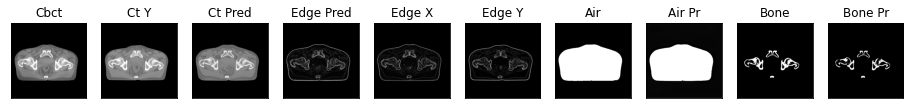

5it [00:02,  2.34it/s]

ssim score = 0.8384528756141663
psnr score = 24.311378479003906
snr score = 14.850836753845215
mae error = 0.023258818313479424
air dice score = 0.996177460883347
bone dice score = 0.8050814584968475
contour dice score = 0.7631102800369263


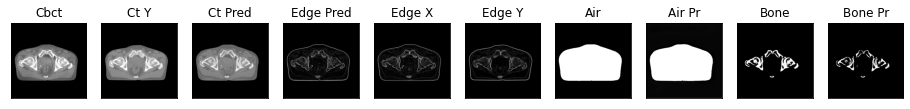

6it [00:02,  2.44it/s]

ssim score = 0.8365547060966492
psnr score = 24.06845474243164
snr score = 14.583858489990234
mae error = 0.023402951657772064
air dice score = 0.9961930198720415
bone dice score = 0.7907937999080245
contour dice score = 0.7569528222084045


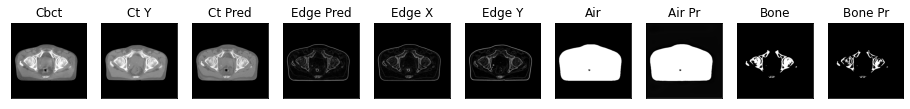

7it [00:02,  2.52it/s]

ssim score = 0.8402981758117676
psnr score = 24.66533660888672
snr score = 14.99520206451416
mae error = 0.021312598139047623
air dice score = 0.9966816709941988
bone dice score = 0.8278713320578011
contour dice score = 0.726500928401947


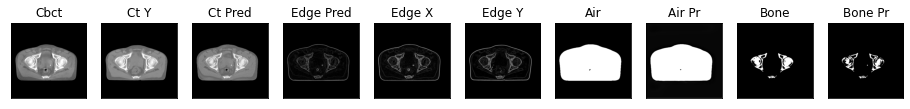

8it [00:03,  2.58it/s]

ssim score = 0.8376626968383789
psnr score = 24.98217010498047
snr score = 15.217483520507812
mae error = 0.02075520157814026
air dice score = 0.9968542044767121
bone dice score = 0.8790237744595095
contour dice score = 0.7579075694084167


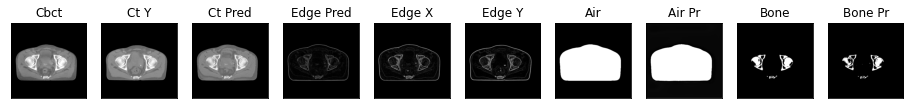

9it [00:03,  2.61it/s]

ssim score = 0.8411135077476501
psnr score = 24.982234954833984
snr score = 15.202263832092285
mae error = 0.020744262263178825
air dice score = 0.996853813989367
bone dice score = 0.8859792689592364
contour dice score = 0.7182926535606384


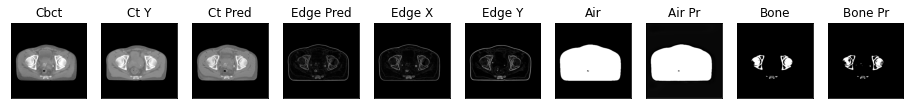

10it [00:04,  2.64it/s]

ssim score = 0.8493830561637878
psnr score = 25.278717041015625
snr score = 15.531011581420898
mae error = 0.020270420238375664
air dice score = 0.9969367124798365
bone dice score = 0.9109270396016006
contour dice score = 0.7008547186851501


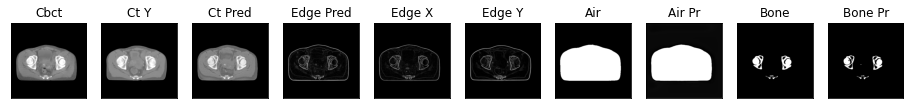

11it [00:04,  2.65it/s]

ssim score = 0.8471521139144897
psnr score = 24.460010528564453
snr score = 14.736018180847168
mae error = 0.02170734852552414
air dice score = 0.9965225108091131
bone dice score = 0.8872862626510726
contour dice score = 0.6911314725875854


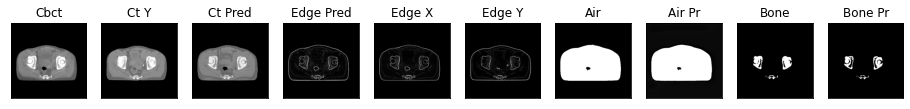

12it [00:04,  2.29it/s]

ssim score = 0.8505864143371582
psnr score = 24.03338623046875
snr score = 14.277471542358398
mae error = 0.022153068333864212
air dice score = 0.9962542127064656
bone dice score = 0.922519037834854
contour dice score = 0.688725471496582


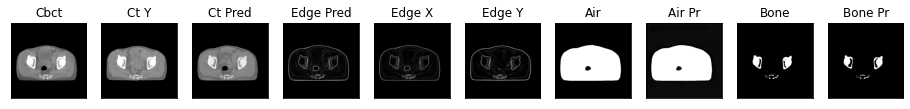

13it [00:05,  2.40it/s]

ssim score = 0.847287118434906
psnr score = 23.989181518554688
snr score = 14.091309547424316
mae error = 0.021657096222043037
air dice score = 0.995647603027759
bone dice score = 0.8963130573686102
contour dice score = 0.6662554144859314


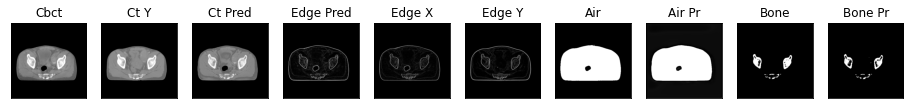

14it [00:05,  2.49it/s]

ssim score = 0.8484410643577576
psnr score = 24.085481643676758
snr score = 14.101947784423828
mae error = 0.021485522389411926
air dice score = 0.9942352767278394
bone dice score = 0.8922121896177735
contour dice score = 0.6769420504570007


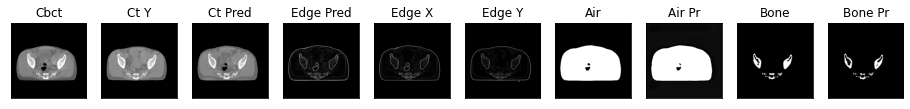

15it [00:06,  2.54it/s]

ssim score = 0.8425535559654236
psnr score = 23.795867919921875
snr score = 13.835819244384766
mae error = 0.022690022364258766
air dice score = 0.994177398104473
bone dice score = 0.8947225981069726
contour dice score = 0.7116948366165161


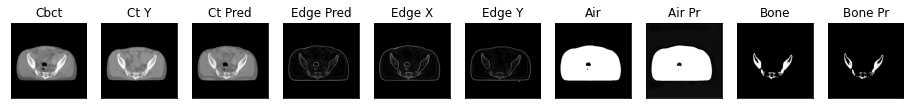

16it [00:06,  2.57it/s]

ssim score = 0.8433555960655212
psnr score = 23.241973876953125
snr score = 13.279379844665527
mae error = 0.02365613728761673
air dice score = 0.9938431452609476
bone dice score = 0.8957086463785088
contour dice score = 0.6817325949668884


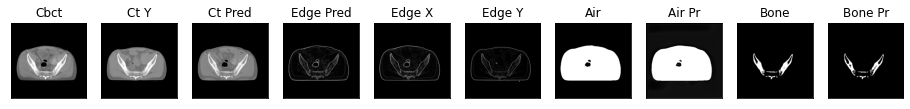

17it [00:06,  2.60it/s]

ssim score = 0.8370072841644287
psnr score = 22.7086181640625
snr score = 12.644267082214355
mae error = 0.02469799295067787
air dice score = 0.9926234487546726
bone dice score = 0.869122257055001
contour dice score = 0.6278637647628784


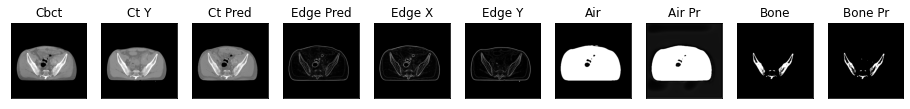

18it [00:07,  2.63it/s]

ssim score = 0.8327441215515137
psnr score = 22.464811325073242
snr score = 12.349775314331055
mae error = 0.025463970378041267
air dice score = 0.9916023281971852
bone dice score = 0.8591074208632705
contour dice score = 0.5652450919151306


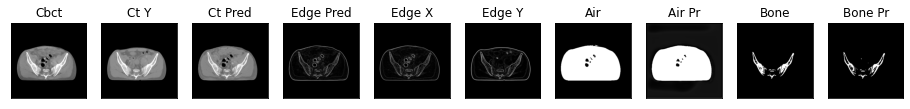

19it [00:07,  2.66it/s]

ssim score = 0.8375016450881958
psnr score = 22.563764572143555
snr score = 12.436420440673828
mae error = 0.025471791625022888
air dice score = 0.9926667033148341
bone dice score = 0.8734530938140592
contour dice score = 0.6101265549659729


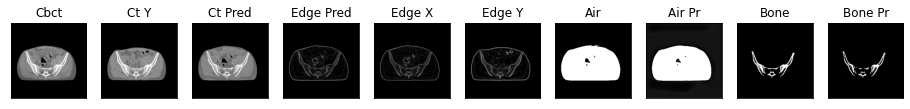

20it [00:07,  2.67it/s]

ssim score = 0.8351736068725586
psnr score = 22.528322219848633
snr score = 12.336130142211914
mae error = 0.025286056101322174
air dice score = 0.993493804680915
bone dice score = 0.8889204545470324
contour dice score = 0.6449552774429321


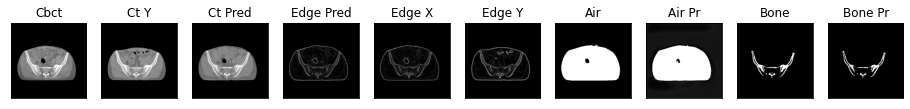

21it [00:08,  2.68it/s]

ssim score = 0.8361682295799255
psnr score = 22.637575149536133
snr score = 12.38595199584961
mae error = 0.024568527936935425
air dice score = 0.9928043084761751
bone dice score = 0.8946278138393229
contour dice score = 0.5708763003349304


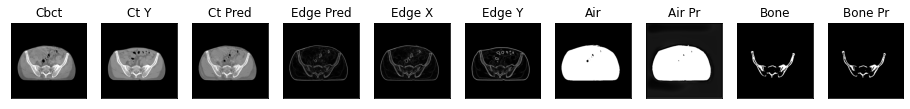

22it [00:08,  2.30it/s]

ssim score = 0.8404057621955872
psnr score = 22.8109188079834
snr score = 12.525869369506836
mae error = 0.0239409152418375
air dice score = 0.9930930014356687
bone dice score = 0.8916863362196212
contour dice score = 0.583818793296814


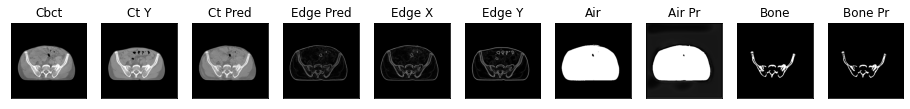

23it [00:09,  2.41it/s]

ssim score = 0.8424777388572693
psnr score = 22.814189910888672
snr score = 12.480578422546387
mae error = 0.0238188523799181
air dice score = 0.9888449654671155
bone dice score = 0.8749839723057445
contour dice score = 0.5306930541992188


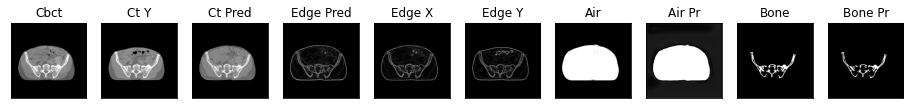

24it [00:09,  2.49it/s]

ssim score = 0.8413709998130798
psnr score = 22.640474319458008
snr score = 12.209859848022461
mae error = 0.024149354547262192
air dice score = 0.9861250014369463
bone dice score = 0.8854064642521375
contour dice score = 0.43775099515914917


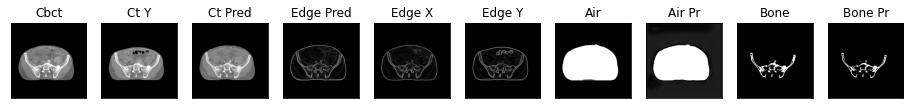

25it [00:09,  2.56it/s]

ssim score = 0.8435049057006836
psnr score = 22.80543327331543
snr score = 12.292084693908691
mae error = 0.023590365424752235
air dice score = 0.9759466152039993
bone dice score = 0.8832647130069838
contour dice score = 0.5671641826629639


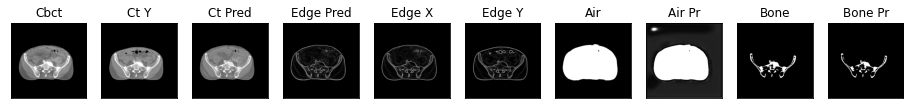

26it [00:10,  2.62it/s]

ssim score = 0.8427206873893738
psnr score = 22.9063720703125
snr score = 12.301836967468262
mae error = 0.023553121834993362
air dice score = 0.9691745283019232
bone dice score = 0.8904142011847287
contour dice score = 0.4746703803539276


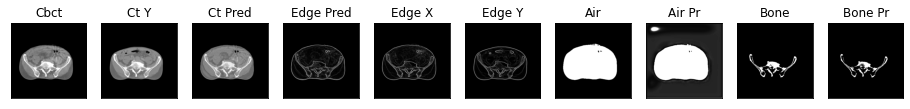

27it [00:10,  2.66it/s]

ssim score = 0.8388679027557373
psnr score = 22.70952033996582
snr score = 12.06387996673584
mae error = 0.023974455893039703
air dice score = 0.9607023114197155
bone dice score = 0.8950375266058581
contour dice score = 0.43156424164772034


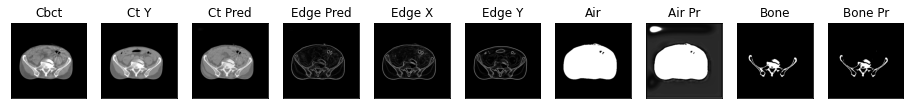

28it [00:11,  2.68it/s]

ssim score = 0.8068336844444275
psnr score = 23.75522232055664
snr score = 15.12738037109375
mae error = 0.027434097602963448
air dice score = 0.9965840738632166
bone dice score = 0.9794628751981213
contour dice score = 0.46349745988845825


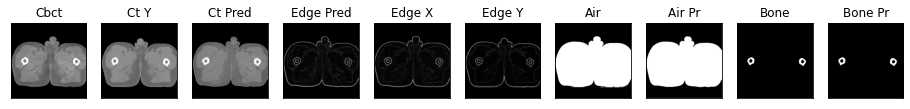

29it [00:11,  2.70it/s]

ssim score = 0.815803050994873
psnr score = 24.374862670898438
snr score = 15.786276817321777
mae error = 0.026423515751957893
air dice score = 0.995917316463148
bone dice score = 0.9760284107731273
contour dice score = 0.4052232503890991


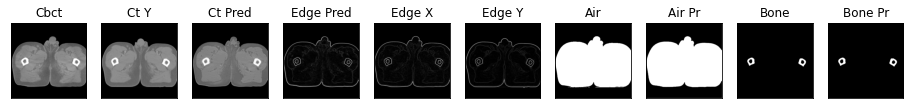

30it [00:11,  2.72it/s]

ssim score = 0.8180843591690063
psnr score = 24.790027618408203
snr score = 16.28889274597168
mae error = 0.026758013293147087
air dice score = 0.9958898854648108
bone dice score = 0.9660090325655809
contour dice score = 0.3527321219444275


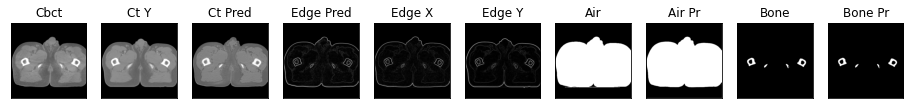

31it [00:12,  2.73it/s]

ssim score = 0.8249366879463196
psnr score = 24.848596572875977
snr score = 16.51001739501953
mae error = 0.028734544292092323
air dice score = 0.9967483908470552
bone dice score = 0.9543582138745369
contour dice score = 0.3397790193557739


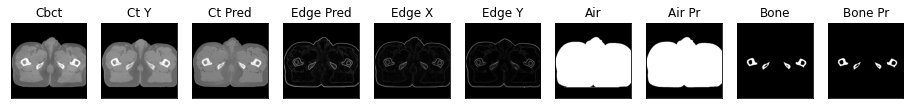

32it [00:12,  2.33it/s]

ssim score = 0.8292316198348999
psnr score = 25.03225326538086
snr score = 16.821815490722656
mae error = 0.02889915741980076
air dice score = 0.9966048954633464
bone dice score = 0.9284980179132507
contour dice score = 0.28186047077178955


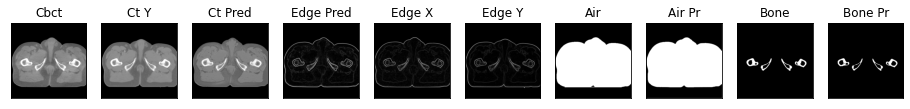

33it [00:13,  2.44it/s]

ssim score = 0.8325609564781189
psnr score = 25.11191177368164
snr score = 17.004711151123047
mae error = 0.029647184535861015
air dice score = 0.996967021615228
bone dice score = 0.904177545693157
contour dice score = 0.2859804332256317


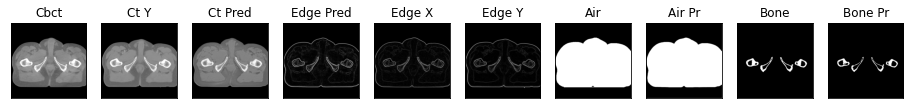

34it [00:13,  2.52it/s]

ssim score = 0.8329399228096008
psnr score = 25.152729034423828
snr score = 17.112632751464844
mae error = 0.03050985559821129
air dice score = 0.9969249913253665
bone dice score = 0.8754299754315058
contour dice score = 0.25500231981277466


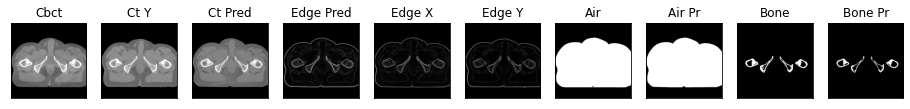

35it [00:13,  2.59it/s]

ssim score = 0.8293520212173462
psnr score = 25.134675979614258
snr score = 17.084688186645508
mae error = 0.030387911945581436
air dice score = 0.9971670374368564
bone dice score = 0.8817677001401923
contour dice score = 0.31832945346832275


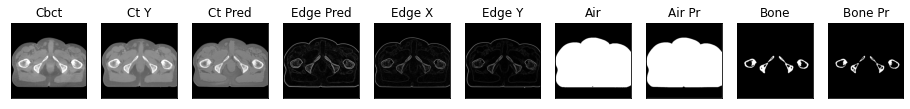

36it [00:14,  2.63it/s]

ssim score = 0.8292841911315918
psnr score = 25.297849655151367
snr score = 17.23419761657715
mae error = 0.03000452183187008
air dice score = 0.9971135591303796
bone dice score = 0.8907333712348978
contour dice score = 0.302552193403244


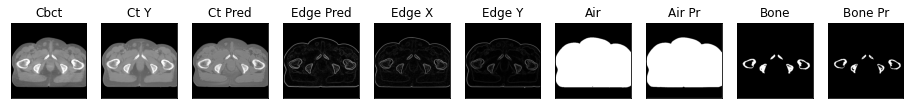

37it [00:14,  2.66it/s]

ssim score = 0.8374271988868713
psnr score = 25.57888412475586
snr score = 17.52723503112793
mae error = 0.029652182012796402
air dice score = 0.9973493087995832
bone dice score = 0.886396526774163
contour dice score = 0.31012070178985596


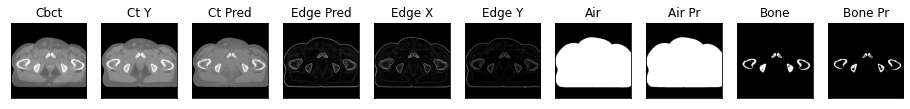

38it [00:14,  2.69it/s]

ssim score = 0.8394981026649475
psnr score = 25.40479278564453
snr score = 17.392227172851562
mae error = 0.03030765987932682
air dice score = 0.9972549019607859
bone dice score = 0.8880089097897784
contour dice score = 0.32074591517448425


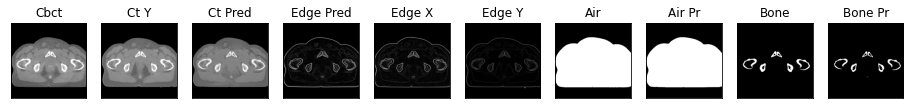

39it [00:15,  2.71it/s]

ssim score = 0.832131564617157
psnr score = 24.842586517333984
snr score = 16.971309661865234
mae error = 0.03240898996591568
air dice score = 0.9971054461595172
bone dice score = 0.8585059091417271
contour dice score = 0.3394109308719635


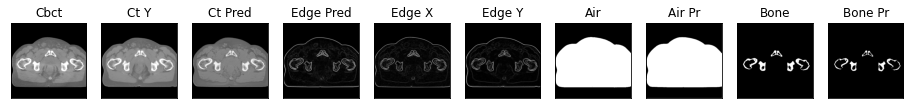

40it [00:15,  2.72it/s]

ssim score = 0.8297993540763855
psnr score = 24.422218322753906
snr score = 16.6456298828125
mae error = 0.03478631004691124
air dice score = 0.9970124382550752
bone dice score = 0.8034573468639284
contour dice score = 0.2811621427536011


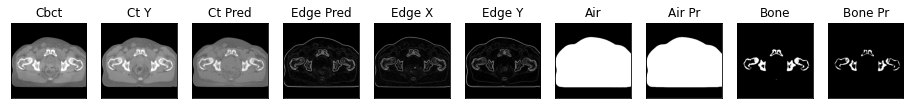

41it [00:16,  2.73it/s]

ssim score = 0.8217519521713257
psnr score = 23.807886123657227
snr score = 15.997248649597168
mae error = 0.035697560757398605
air dice score = 0.9970026987652569
bone dice score = 0.7458531935200585
contour dice score = 0.32879287004470825


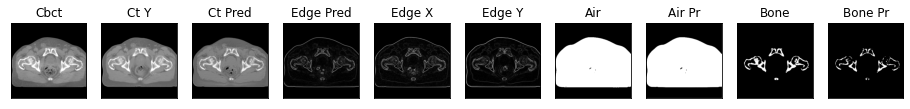

42it [00:16,  2.33it/s]

ssim score = 0.8141646385192871
psnr score = 22.696760177612305
snr score = 14.958309173583984
mae error = 0.03939943388104439
air dice score = 0.9960081280284745
bone dice score = 0.6811655764193257
contour dice score = 0.2978322207927704


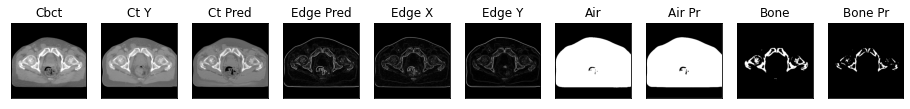

43it [00:16,  2.44it/s]

ssim score = 0.8189969658851624
psnr score = 23.338165283203125
snr score = 15.463621139526367
mae error = 0.036286864429712296
air dice score = 0.9967257005372765
bone dice score = 0.750495255971739
contour dice score = 0.2900330722332001


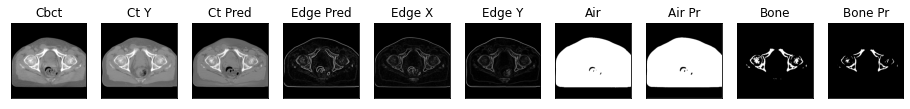

44it [00:17,  2.51it/s]

ssim score = 0.8341814875602722
psnr score = 24.209243774414062
snr score = 16.156137466430664
mae error = 0.0317356176674366
air dice score = 0.9970745034513624
bone dice score = 0.7700670830468416
contour dice score = 0.3910984992980957


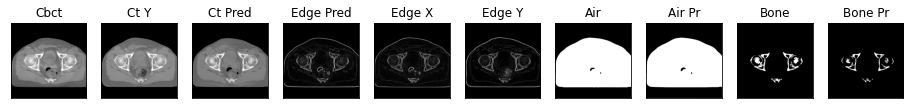

45it [00:17,  2.58it/s]

ssim score = 0.8282031416893005
psnr score = 24.565673828125
snr score = 16.421977996826172
mae error = 0.03115791454911232
air dice score = 0.9975249472008922
bone dice score = 0.8052079383162026
contour dice score = 0.3910561501979828


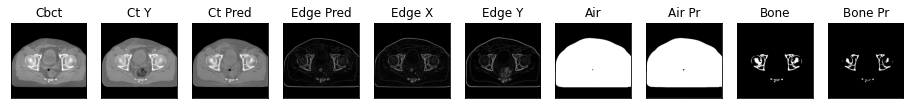

46it [00:18,  2.63it/s]

ssim score = 0.828031599521637
psnr score = 24.36910629272461
snr score = 16.241104125976562
mae error = 0.03207351639866829
air dice score = 0.9978852184058935
bone dice score = 0.7867275787474545
contour dice score = 0.33190271258354187


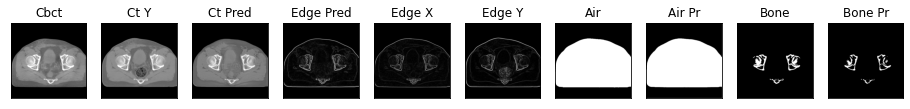

47it [00:18,  2.66it/s]

ssim score = 0.8153964877128601
psnr score = 24.1070556640625
snr score = 15.989086151123047
mae error = 0.03277180716395378
air dice score = 0.9977397678680527
bone dice score = 0.7693327441474885
contour dice score = 0.30305927991867065


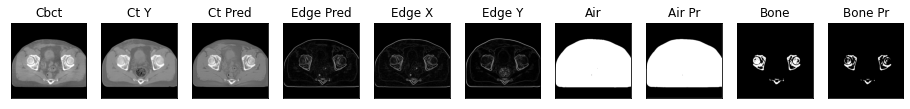

48it [00:18,  2.68it/s]

ssim score = 0.8217676877975464
psnr score = 24.097387313842773
snr score = 16.0410099029541
mae error = 0.032881565392017365
air dice score = 0.9975049808429134
bone dice score = 0.7987394958004334
contour dice score = 0.31393128633499146


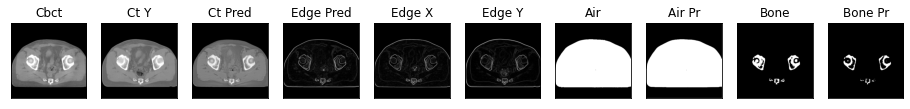

49it [00:19,  2.70it/s]

ssim score = 0.8198432922363281
psnr score = 24.271461486816406
snr score = 16.285165786743164
mae error = 0.03330633044242859
air dice score = 0.997395321407511
bone dice score = 0.8627718716486612
contour dice score = 0.29551953077316284


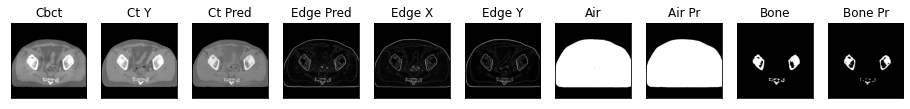

50it [00:19,  2.72it/s]

ssim score = 0.8262603878974915
psnr score = 24.444286346435547
snr score = 16.338882446289062
mae error = 0.0322180911898613
air dice score = 0.9974688832368821
bone dice score = 0.8345864661672424
contour dice score = 0.3021925687789917


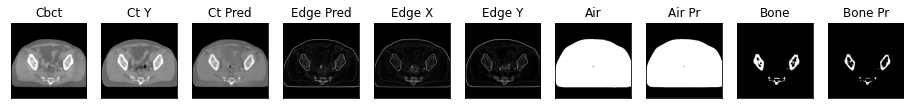

51it [00:19,  2.73it/s]

ssim score = 0.8159686923027039
psnr score = 23.55839729309082
snr score = 15.534622192382812
mae error = 0.03481714800000191
air dice score = 0.9968737908203708
bone dice score = 0.8183593750017738
contour dice score = 0.2854406237602234


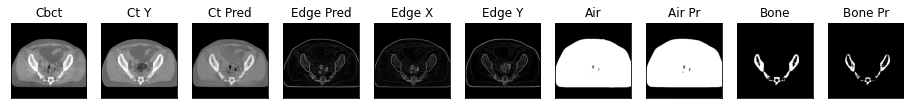

52it [00:20,  2.33it/s]

ssim score = 0.81541907787323
psnr score = 23.486034393310547
snr score = 15.54240608215332
mae error = 0.03601870685815811
air dice score = 0.9960140794976539
bone dice score = 0.7721948735378358
contour dice score = 0.27473583817481995


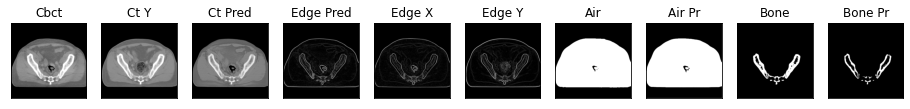

53it [00:20,  2.43it/s]

ssim score = 0.7966146469116211
psnr score = 23.06482696533203
snr score = 15.142759323120117
mae error = 0.037481289356946945
air dice score = 0.996489683092995
bone dice score = 0.7554788610892539
contour dice score = 0.24131274223327637


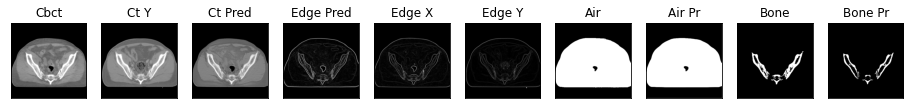

54it [00:21,  2.52it/s]

ssim score = 0.8038312196731567
psnr score = 23.497177124023438
snr score = 15.58764362335205
mae error = 0.036607902497053146
air dice score = 0.9965918738629493
bone dice score = 0.7663454024505831
contour dice score = 0.19923003017902374


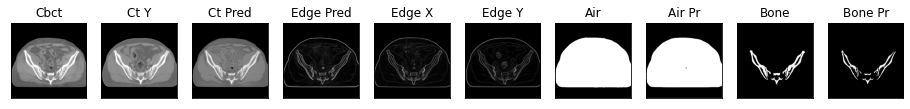

55it [00:21,  2.58it/s]

ssim score = 0.7673624753952026
psnr score = 20.699073791503906
snr score = 10.5792818069458
mae error = 0.03255738317966461
air dice score = 0.9959224372785421
bone dice score = 0.9577080491143872
contour dice score = 0.6762430667877197


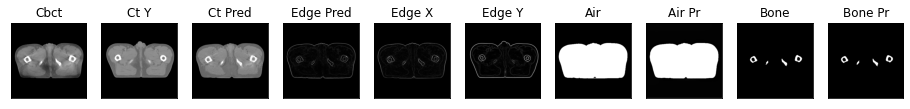

56it [00:21,  2.64it/s]

ssim score = 0.75736004114151
psnr score = 20.35231590270996
snr score = 10.445503234863281
mae error = 0.03491632640361786
air dice score = 0.9960957212291873
bone dice score = 0.9394535519138917
contour dice score = 0.6842684149742126


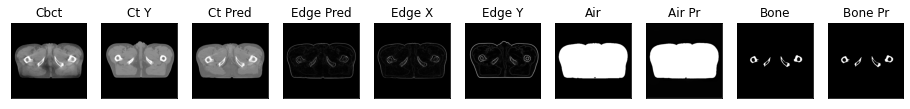

57it [00:22,  2.68it/s]

ssim score = 0.7564700841903687
psnr score = 20.328662872314453
snr score = 10.552989959716797
mae error = 0.035644590854644775
air dice score = 0.9966270068428638
bone dice score = 0.9285277947479428
contour dice score = 0.6736035346984863


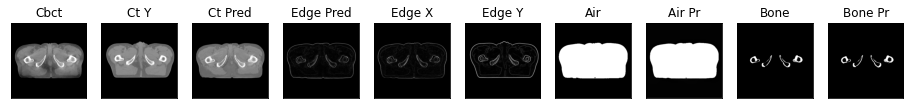

58it [00:22,  2.70it/s]

ssim score = 0.7607026100158691
psnr score = 20.662090301513672
snr score = 10.95682144165039
mae error = 0.03462351858615875
air dice score = 0.9958248543961864
bone dice score = 0.924406047517683
contour dice score = 0.6224657297134399


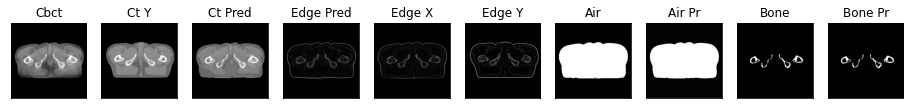

59it [00:23,  2.72it/s]

ssim score = 0.7654666304588318
psnr score = 20.83466339111328
snr score = 11.176959991455078
mae error = 0.03404828906059265
air dice score = 0.9951987406532903
bone dice score = 0.9128283212806847
contour dice score = 0.5762526988983154


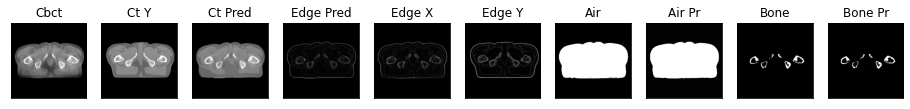

60it [00:23,  2.72it/s]

ssim score = 0.7670527100563049
psnr score = 21.02447509765625
snr score = 11.372389793395996
mae error = 0.033237989991903305
air dice score = 0.9948651782367294
bone dice score = 0.9137670196688017
contour dice score = 0.6419098377227783


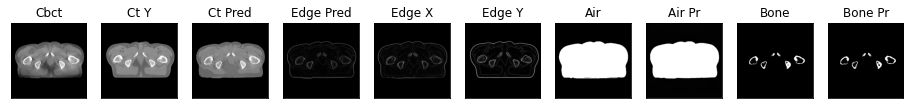

61it [00:23,  2.74it/s]

ssim score = 0.7695332169532776
psnr score = 21.172611236572266
snr score = 11.514020919799805
mae error = 0.032750267535448074
air dice score = 0.9944309780106216
bone dice score = 0.9238694905566901
contour dice score = 0.592238187789917


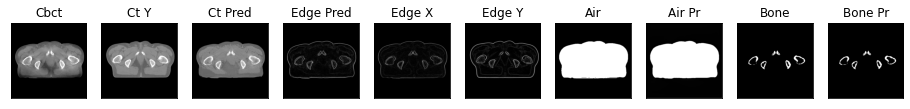

62it [00:24,  2.34it/s]

ssim score = 0.7667713761329651
psnr score = 21.01066780090332
snr score = 11.36618709564209
mae error = 0.033132560551166534
air dice score = 0.9946334285467024
bone dice score = 0.9249622926107661
contour dice score = 0.6036131978034973


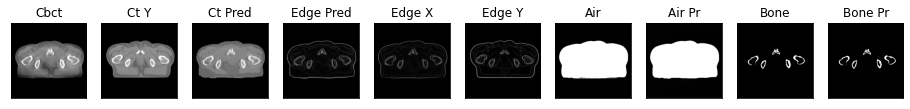

63it [00:24,  2.45it/s]

ssim score = 0.766324520111084
psnr score = 20.96839141845703
snr score = 11.38192081451416
mae error = 0.03359634429216385
air dice score = 0.9955550943461531
bone dice score = 0.8995347234206525
contour dice score = 0.612593412399292


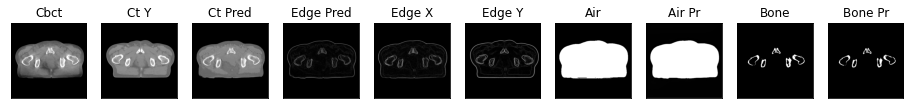

64it [00:25,  2.52it/s]

ssim score = 0.7571849822998047
psnr score = 20.77554702758789
snr score = 11.28763198852539
mae error = 0.035231903195381165
air dice score = 0.9949799023582426
bone dice score = 0.8887065003301263
contour dice score = 0.6029567122459412


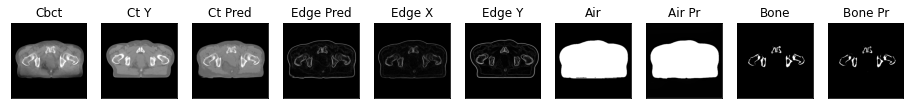

65it [00:25,  2.59it/s]

ssim score = 0.7480394840240479
psnr score = 20.517162322998047
snr score = 11.065077781677246
mae error = 0.036876048892736435
air dice score = 0.9956181506701943
bone dice score = 0.8785341968112694
contour dice score = 0.5946236848831177


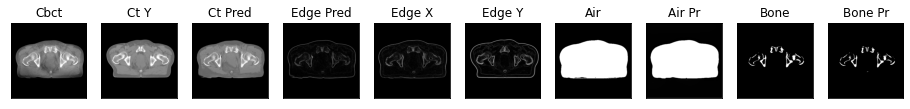

66it [00:25,  2.64it/s]

ssim score = 0.7383285164833069
psnr score = 20.35638427734375
snr score = 10.937003135681152
mae error = 0.037950046360492706
air dice score = 0.9963712659294578
bone dice score = 0.8380924771729512
contour dice score = 0.6563169360160828


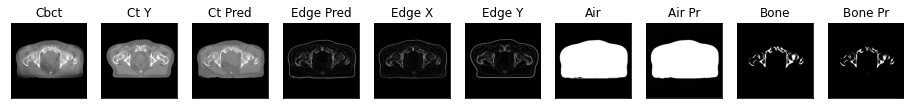

67it [00:26,  2.68it/s]

ssim score = 0.7368349432945251
psnr score = 20.370670318603516
snr score = 11.068107604980469
mae error = 0.038450732827186584
air dice score = 0.9962083759640301
bone dice score = 0.8747209821446049
contour dice score = 0.6870390176773071


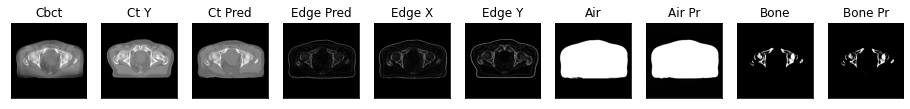

68it [00:26,  2.68it/s]

ssim score = 0.7385047078132629
psnr score = 20.377124786376953
snr score = 11.058579444885254
mae error = 0.03805474191904068
air dice score = 0.9969914729748341
bone dice score = 0.8765148028857721
contour dice score = 0.7279651761054993


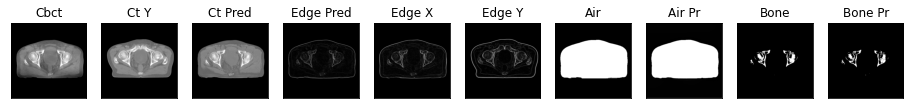

69it [00:26,  2.70it/s]

ssim score = 0.747380793094635
psnr score = 20.948814392089844
snr score = 11.431103706359863
mae error = 0.03483286872506142
air dice score = 0.9967188332102208
bone dice score = 0.8946692357113893
contour dice score = 0.6691729426383972


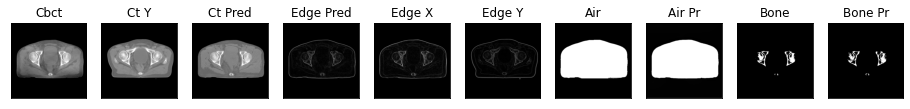

70it [00:27,  2.72it/s]

ssim score = 0.7596359252929688
psnr score = 21.644187927246094
snr score = 11.95608139038086
mae error = 0.03180205449461937
air dice score = 0.9965171141803238
bone dice score = 0.915439010018924
contour dice score = 0.6092572808265686


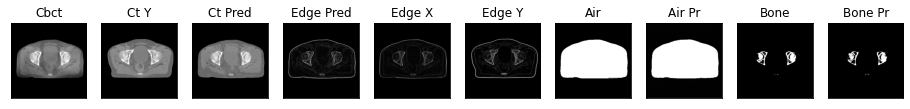

71it [00:27,  2.72it/s]

ssim score = 0.7640714049339294
psnr score = 22.028350830078125
snr score = 12.354413986206055
mae error = 0.03036160208284855
air dice score = 0.9960688255295129
bone dice score = 0.9053694097868307
contour dice score = 0.6054458022117615


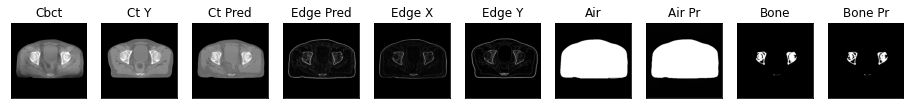

72it [00:28,  2.32it/s]

ssim score = 0.7703663110733032
psnr score = 22.19687271118164
snr score = 12.604764938354492
mae error = 0.030306437984108925
air dice score = 0.9964873896433577
bone dice score = 0.9182945957519136
contour dice score = 0.6001085042953491


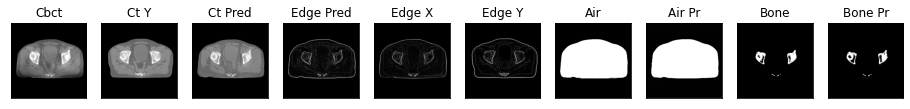

73it [00:28,  2.44it/s]

ssim score = 0.76938796043396
psnr score = 22.110803604125977
snr score = 12.61086654663086
mae error = 0.030653847381472588
air dice score = 0.9965070115353843
bone dice score = 0.9245074862108037
contour dice score = 0.6042928099632263


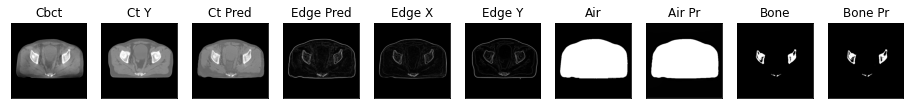

74it [00:28,  2.51it/s]

ssim score = 0.7667897939682007
psnr score = 22.354328155517578
snr score = 12.790966987609863
mae error = 0.02981553226709366
air dice score = 0.9966640352440885
bone dice score = 0.9310582557750593
contour dice score = 0.6280814409255981


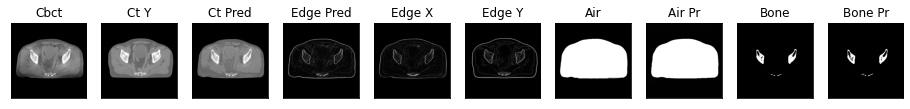

75it [00:29,  2.59it/s]

ssim score = 0.7662688493728638
psnr score = 22.45315170288086
snr score = 12.853397369384766
mae error = 0.029316021129488945
air dice score = 0.9963871361693497
bone dice score = 0.9311056880057986
contour dice score = 0.5779669880867004


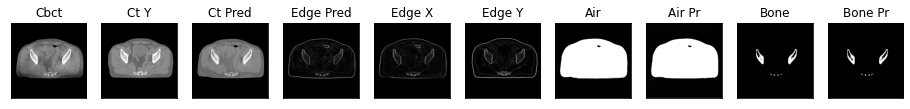

76it [00:29,  2.62it/s]

ssim score = 0.760685920715332
psnr score = 22.13043975830078
snr score = 12.568429946899414
mae error = 0.031110426411032677
air dice score = 0.9964880730209388
bone dice score = 0.8947185545536012
contour dice score = 0.6419098377227783


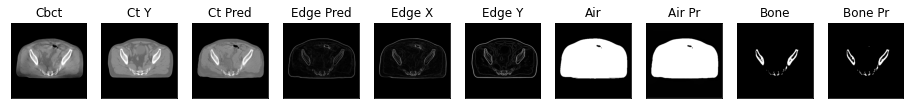

77it [00:29,  2.67it/s]

ssim score = 0.7592782974243164
psnr score = 21.970375061035156
snr score = 12.538867950439453
mae error = 0.03226560354232788
air dice score = 0.9962141147310016
bone dice score = 0.8961178456360884
contour dice score = 0.6089743375778198


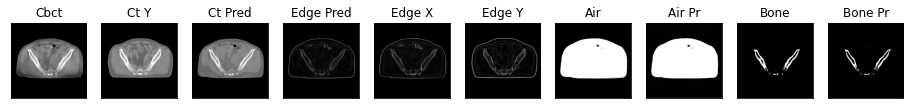

78it [00:30,  2.70it/s]

ssim score = 0.764697253704071
psnr score = 21.903053283691406
snr score = 12.489295959472656
mae error = 0.03275434300303459
air dice score = 0.9960815714602143
bone dice score = 0.8844905905275067
contour dice score = 0.6054750680923462


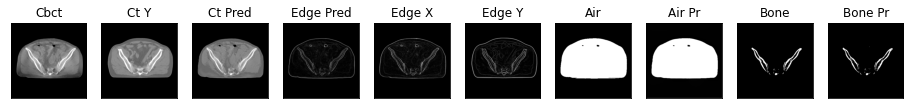

79it [00:30,  2.71it/s]

ssim score = 0.7675695419311523
psnr score = 22.29096221923828
snr score = 12.865936279296875
mae error = 0.03141765668988228
air dice score = 0.996031338738927
bone dice score = 0.8984293193735003
contour dice score = 0.6245954632759094


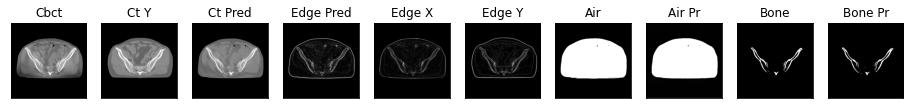

80it [00:31,  2.70it/s]

ssim score = 0.771853506565094
psnr score = 22.319486618041992
snr score = 12.893720626831055
mae error = 0.031215200200676918
air dice score = 0.9960686020360898
bone dice score = 0.8900822285636838
contour dice score = 0.6126224398612976


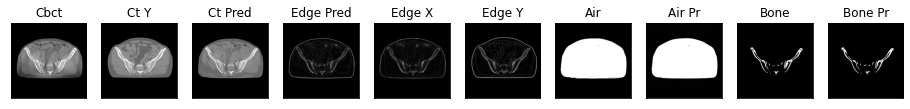

81it [00:31,  2.72it/s]

ssim score = 0.8053802847862244
psnr score = 23.568893432617188
snr score = 14.003028869628906
mae error = 0.023185767233371735
air dice score = 0.9964615421315062
bone dice score = 0.9261793302151178
contour dice score = 0.5870488286018372


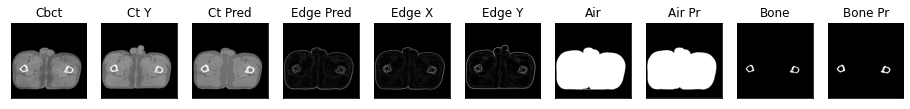

82it [00:32,  2.33it/s]

ssim score = 0.8057010769844055
psnr score = 23.787967681884766
snr score = 14.286498069763184
mae error = 0.023099372163414955
air dice score = 0.9964762025156465
bone dice score = 0.9135963482258365
contour dice score = 0.5552645325660706


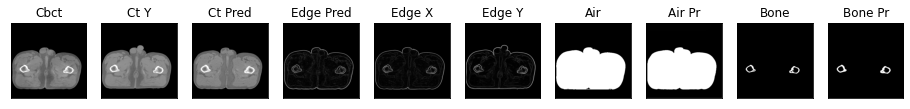

83it [00:32,  2.44it/s]

ssim score = 0.8115635514259338
psnr score = 24.89234161376953
snr score = 15.530082702636719
mae error = 0.022531146183609962
air dice score = 0.9970631883152409
bone dice score = 0.9383636762461425
contour dice score = 0.6095334887504578


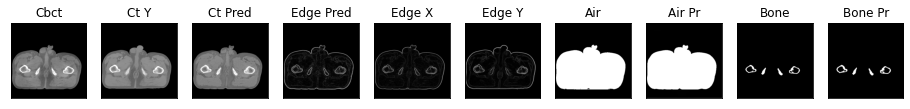

84it [00:32,  2.51it/s]

ssim score = 0.8138301372528076
psnr score = 24.883792877197266
snr score = 15.643023490905762
mae error = 0.023151451721787453
air dice score = 0.9972954488933122
bone dice score = 0.9289479232568216
contour dice score = 0.5982555150985718


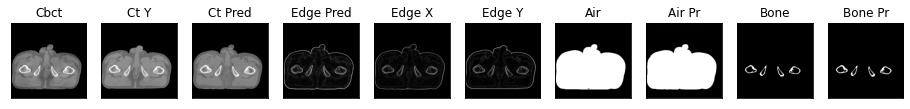

85it [00:33,  2.57it/s]

ssim score = 0.8072931170463562
psnr score = 24.629161834716797
snr score = 15.412564277648926
mae error = 0.024060484021902084
air dice score = 0.9976040753979657
bone dice score = 0.9217204301092103
contour dice score = 0.6355624794960022


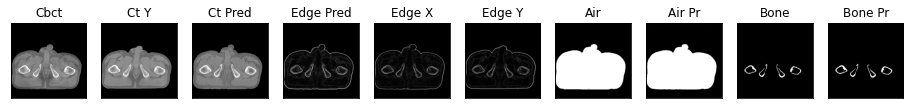

86it [00:33,  2.63it/s]

ssim score = 0.8071144223213196
psnr score = 24.493953704833984
snr score = 15.27296257019043
mae error = 0.02440507523715496
air dice score = 0.9978701487797905
bone dice score = 0.9138308457728591
contour dice score = 0.6356508135795593


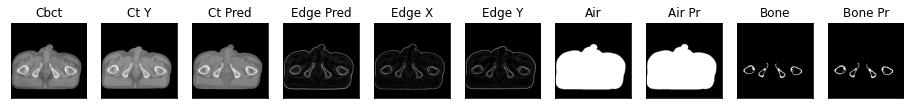

87it [00:33,  2.67it/s]

ssim score = 0.8053966760635376
psnr score = 24.19090461730957
snr score = 14.976165771484375
mae error = 0.02506374381482601
air dice score = 0.9977706907762348
bone dice score = 0.9179378258366878
contour dice score = 0.6028406023979187


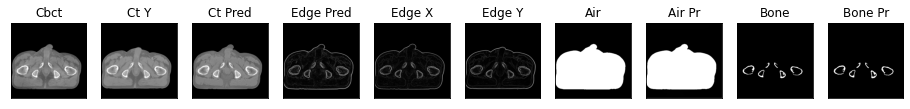

88it [00:34,  2.68it/s]

ssim score = 0.8037324547767639
psnr score = 24.03670310974121
snr score = 14.800409317016602
mae error = 0.02487328089773655
air dice score = 0.9978460632544607
bone dice score = 0.9213395638644599
contour dice score = 0.6389035582542419


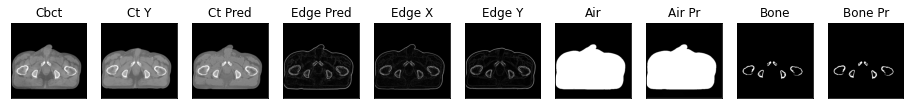

89it [00:34,  2.70it/s]

ssim score = 0.8070369362831116
psnr score = 24.027751922607422
snr score = 14.808366775512695
mae error = 0.024906113743782043
air dice score = 0.9977472228695737
bone dice score = 0.9395898762250214
contour dice score = 0.6154661178588867


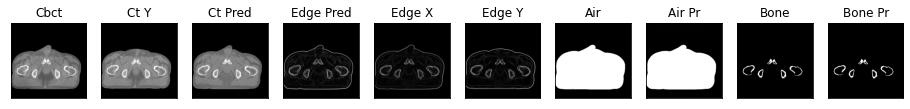

90it [00:34,  2.70it/s]

ssim score = 0.8058153390884399
psnr score = 24.201400756835938
snr score = 15.050610542297363
mae error = 0.02502398006618023
air dice score = 0.9974190831897345
bone dice score = 0.9237637362650453
contour dice score = 0.6043779850006104


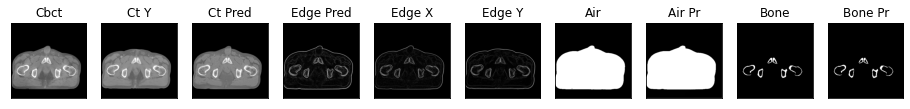

91it [00:35,  2.72it/s]

ssim score = 0.8068861961364746
psnr score = 24.323856353759766
snr score = 15.254425048828125
mae error = 0.0255509614944458
air dice score = 0.9969225468469833
bone dice score = 0.9067176058594919
contour dice score = 0.620096743106842


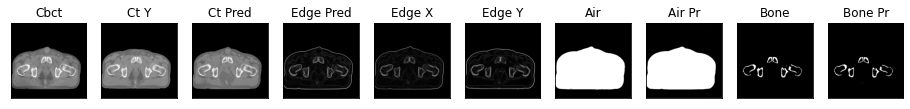

92it [00:35,  2.31it/s]

ssim score = 0.8090973496437073
psnr score = 24.436891555786133
snr score = 15.418161392211914
mae error = 0.02569776028394699
air dice score = 0.9971773400951393
bone dice score = 0.8862015503893612
contour dice score = 0.6917697787284851


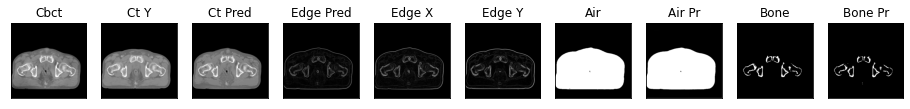

93it [00:36,  2.43it/s]

ssim score = 0.8103504776954651
psnr score = 24.52845573425293
snr score = 15.625992774963379
mae error = 0.026289911940693855
air dice score = 0.9978546865633988
bone dice score = 0.8519780708275007
contour dice score = 0.6803014278411865


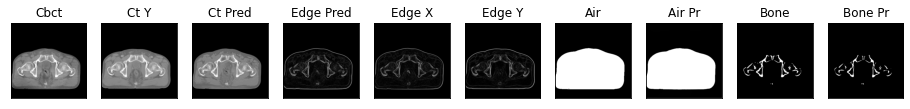

94it [00:36,  2.51it/s]

ssim score = 0.8093463182449341
psnr score = 24.405948638916016
snr score = 15.465253829956055
mae error = 0.026047874242067337
air dice score = 0.9981051446511975
bone dice score = 0.8641711229967277
contour dice score = 0.7036637663841248


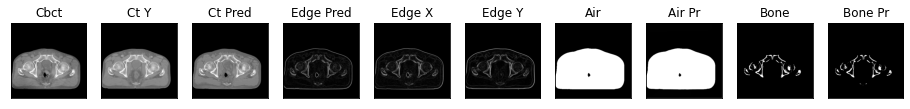

95it [00:36,  2.58it/s]

ssim score = 0.802418053150177
psnr score = 23.74201011657715
snr score = 14.705643653869629
mae error = 0.026420632377266884
air dice score = 0.9973941680521826
bone dice score = 0.8556164768753604
contour dice score = 0.6623446941375732


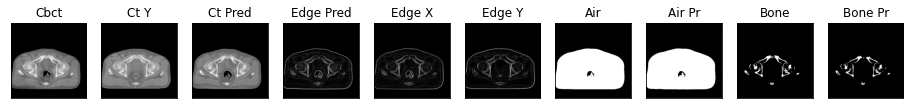

96it [00:37,  2.61it/s]

ssim score = 0.8082405924797058
psnr score = 23.690696716308594
snr score = 14.494569778442383
mae error = 0.025343555957078934
air dice score = 0.9970465391393944
bone dice score = 0.8880157170941713
contour dice score = 0.6753246784210205


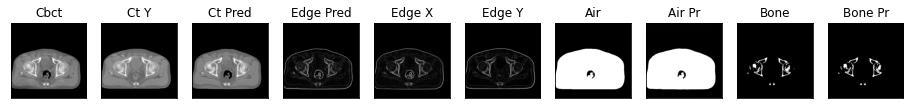

97it [00:37,  2.64it/s]

ssim score = 0.8094971179962158
psnr score = 23.639495849609375
snr score = 14.326945304870605
mae error = 0.02470732294023037
air dice score = 0.9967957059206272
bone dice score = 0.8839816544949213
contour dice score = 0.634782612323761


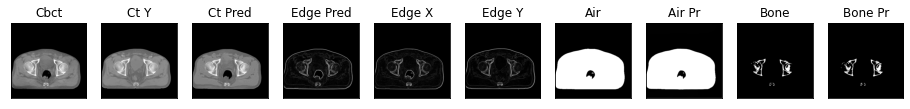

98it [00:38,  2.68it/s]

ssim score = 0.8030114769935608
psnr score = 23.514728546142578
snr score = 14.157085418701172
mae error = 0.02503332681953907
air dice score = 0.997502804228041
bone dice score = 0.8910121457507528
contour dice score = 0.6521264910697937


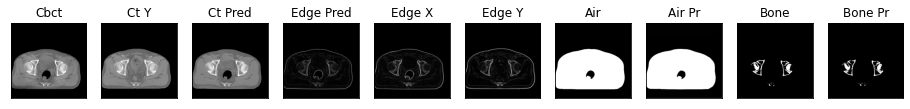

99it [00:38,  2.70it/s]

ssim score = 0.8015409708023071
psnr score = 23.152793884277344
snr score = 13.801823616027832
mae error = 0.026185229420661926
air dice score = 0.9976296903834344
bone dice score = 0.905256220136674
contour dice score = 0.6295081973075867


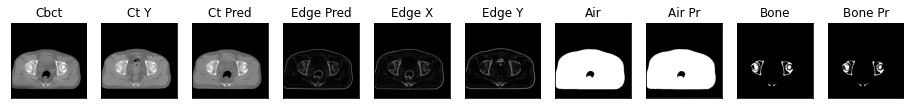

100it [00:38,  2.69it/s]

ssim score = 0.8047204613685608
psnr score = 22.89638328552246
snr score = 13.575514793395996
mae error = 0.027061769738793373
air dice score = 0.9976748580677515
bone dice score = 0.9164057608028114
contour dice score = 0.596606433391571


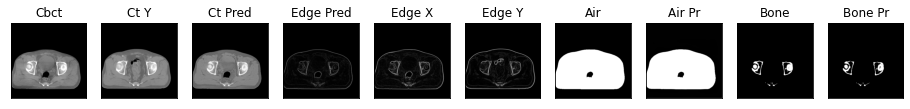

101it [00:39,  2.72it/s]

ssim score = 0.8114885687828064
psnr score = 23.5728816986084
snr score = 14.209427833557129
mae error = 0.02524590864777565
air dice score = 0.9973414730208765
bone dice score = 0.9159825327525593
contour dice score = 0.5600000023841858


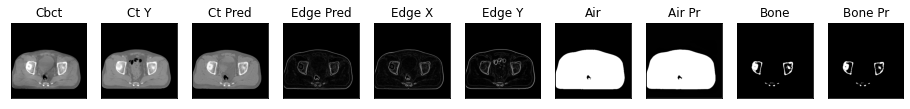

102it [00:39,  2.32it/s]

ssim score = 0.8176308274269104
psnr score = 23.936973571777344
snr score = 14.483314514160156
mae error = 0.02370651811361313
air dice score = 0.997569275644144
bone dice score = 0.9235778586492324
contour dice score = 0.5753424763679504


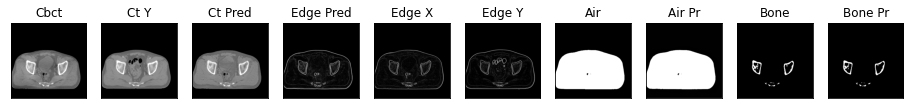

103it [00:40,  2.44it/s]

ssim score = 0.8168144822120667
psnr score = 23.635665893554688
snr score = 14.116281509399414
mae error = 0.024129608646035194
air dice score = 0.9973445213062646
bone dice score = 0.9281071498930844
contour dice score = 0.6029654145240784


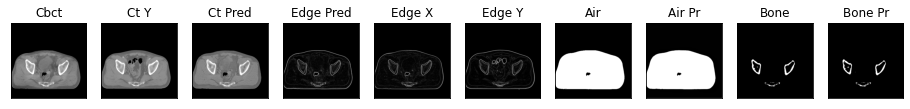

104it [00:40,  2.51it/s]

ssim score = 0.8158668875694275
psnr score = 23.673189163208008
snr score = 14.153501510620117
mae error = 0.024352986365556717
air dice score = 0.9972078047308028
bone dice score = 0.9221706533394829
contour dice score = 0.6031920909881592


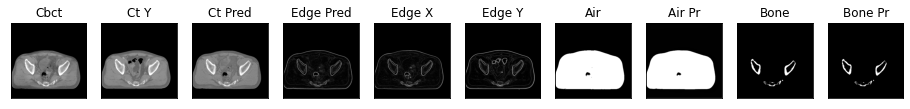

105it [00:40,  2.57it/s]

ssim score = 0.8130961060523987
psnr score = 23.560081481933594
snr score = 14.116559982299805
mae error = 0.02537575364112854
air dice score = 0.99683346033359
bone dice score = 0.8904668378925749
contour dice score = 0.6541436314582825


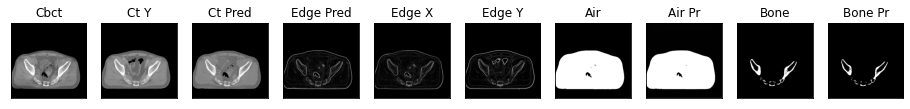

106it [00:41,  2.62it/s]

ssim score = 0.819549024105072
psnr score = 23.755680084228516
snr score = 14.347742080688477
mae error = 0.02509297989308834
air dice score = 0.9971970181043688
bone dice score = 0.8763594733847115
contour dice score = 0.6644591689109802


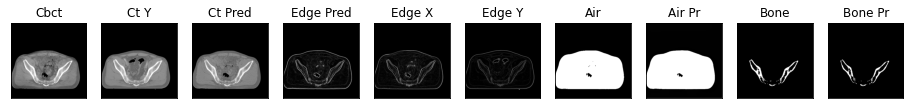

107it [00:41,  2.66it/s]

ssim score = 0.8218450546264648
psnr score = 24.372406005859375
snr score = 14.902769088745117
mae error = 0.023861881345510483
air dice score = 0.9974988007949038
bone dice score = 0.8869826937564036
contour dice score = 0.6917960047721863


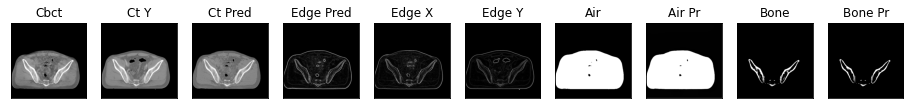

108it [00:41,  2.68it/s]

ssim score = 0.8212960362434387
psnr score = 24.2287654876709
snr score = 14.697868347167969
mae error = 0.023866066709160805
air dice score = 0.9972284818815265
bone dice score = 0.8923794712302896
contour dice score = 0.6494671702384949


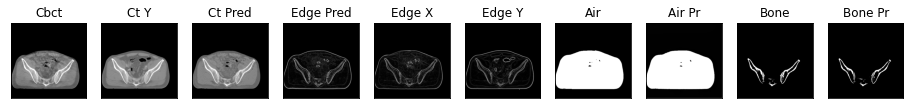

109it [00:42,  2.70it/s]

ssim score = 0.7427688241004944
psnr score = 21.665842056274414
snr score = 13.363151550292969
mae error = 0.03828560188412666
air dice score = 0.9972807251399642
bone dice score = 0.9641089108921996
contour dice score = 0.4432671070098877


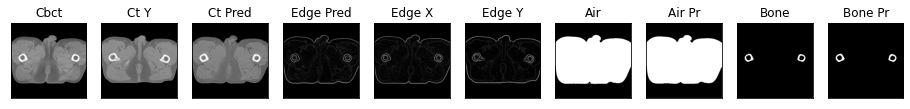

110it [00:42,  2.71it/s]

ssim score = 0.7344286441802979
psnr score = 21.31566047668457
snr score = 13.117257118225098
mae error = 0.04047701880335808
air dice score = 0.9974967752575391
bone dice score = 0.960511679645147
contour dice score = 0.4426666796207428


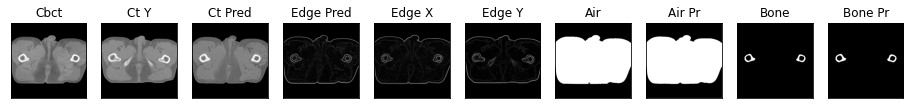

111it [00:43,  2.72it/s]

ssim score = 0.7308191657066345
psnr score = 20.9543514251709
snr score = 12.883906364440918
mae error = 0.04339258000254631
air dice score = 0.9978166707750832
bone dice score = 0.9322602280363903
contour dice score = 0.421146959066391


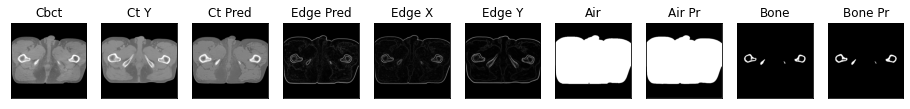

112it [00:43,  2.32it/s]

ssim score = 0.7241646647453308
psnr score = 20.636579513549805
snr score = 12.598423957824707
mae error = 0.04567250609397888
air dice score = 0.9980746610174462
bone dice score = 0.9266943291852231
contour dice score = 0.38631248474121094


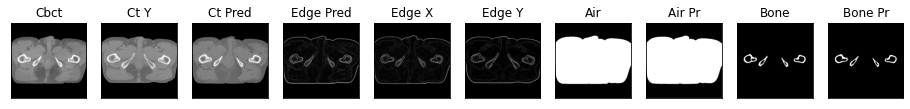

113it [00:43,  2.43it/s]

ssim score = 0.7099108695983887
psnr score = 20.4495849609375
snr score = 12.441667556762695
mae error = 0.04702911525964737
air dice score = 0.9977052300900988
bone dice score = 0.9134177215204486
contour dice score = 0.3934870958328247


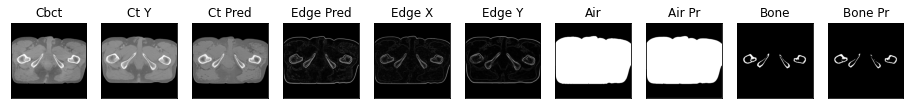

114it [00:44,  2.52it/s]

ssim score = 0.7098243236541748
psnr score = 20.345684051513672
snr score = 12.372179985046387
mae error = 0.047994837164878845
air dice score = 0.9977589829857345
bone dice score = 0.9105770802695672
contour dice score = 0.4153846204280853


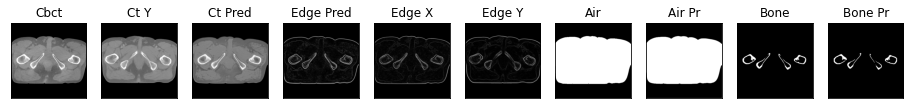

115it [00:44,  2.58it/s]

ssim score = 0.7002722024917603
psnr score = 20.036773681640625
snr score = 12.083581924438477
mae error = 0.04964686185121536
air dice score = 0.9975762214568199
bone dice score = 0.8917812225812842
contour dice score = 0.3752819001674652


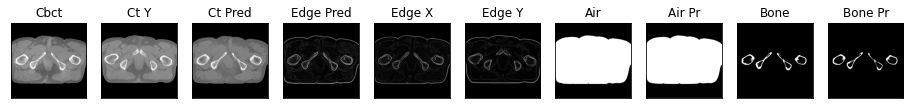

116it [00:45,  2.60it/s]

ssim score = 0.7033162117004395
psnr score = 20.052444458007812
snr score = 12.138328552246094
mae error = 0.04939759522676468
air dice score = 0.9966348687830523
bone dice score = 0.8838709677436383
contour dice score = 0.4039497375488281


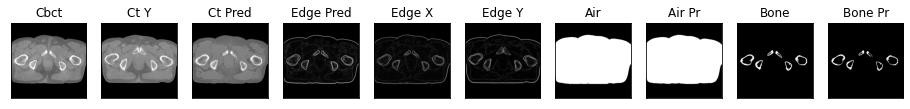

117it [00:45,  2.65it/s]

ssim score = 0.706282377243042
psnr score = 20.137897491455078
snr score = 12.272457122802734
mae error = 0.04930410534143448
air dice score = 0.995904701773087
bone dice score = 0.88243666382177
contour dice score = 0.39703962206840515


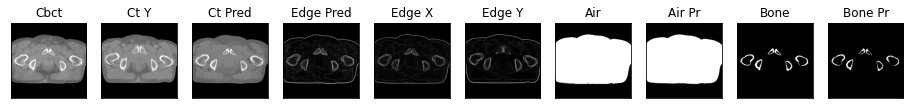

118it [00:45,  2.68it/s]

ssim score = 0.7012509703636169
psnr score = 19.934682846069336
snr score = 12.091856956481934
mae error = 0.05090208724141121
air dice score = 0.9957731146933506
bone dice score = 0.8768934177929373
contour dice score = 0.4110638201236725


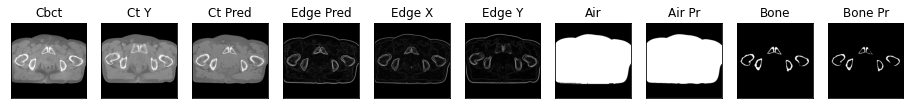

119it [00:46,  2.70it/s]

ssim score = 0.689481258392334
psnr score = 19.851566314697266
snr score = 12.05151653289795
mae error = 0.05238768830895424
air dice score = 0.9965398723391985
bone dice score = 0.8546267087295659
contour dice score = 0.45570698380470276


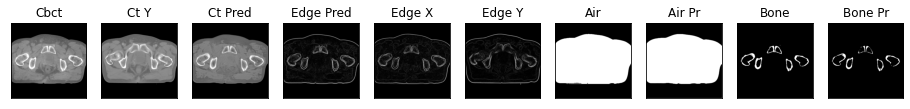

120it [00:46,  2.70it/s]

ssim score = 0.6878323554992676
psnr score = 19.768001556396484
snr score = 12.026291847229004
mae error = 0.05288683623075485
air dice score = 0.9966723087729014
bone dice score = 0.8272727272748492
contour dice score = 0.37380626797676086


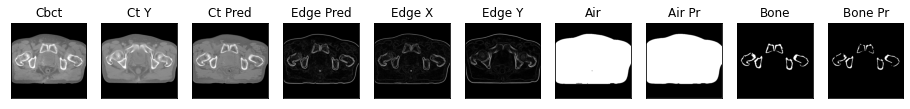

121it [00:46,  2.71it/s]

ssim score = 0.6847423315048218
psnr score = 19.781879425048828
snr score = 11.96479606628418
mae error = 0.05308196693658829
air dice score = 0.9972390308998474
bone dice score = 0.7787836583126881
contour dice score = 0.40931931138038635


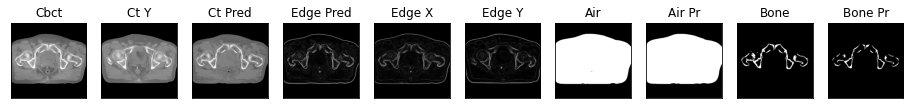

122it [00:47,  2.30it/s]

ssim score = 0.6845385432243347
psnr score = 19.808862686157227
snr score = 11.884561538696289
mae error = 0.05259910970926285
air dice score = 0.9970373182840625
bone dice score = 0.7668452856029317
contour dice score = 0.4038461446762085


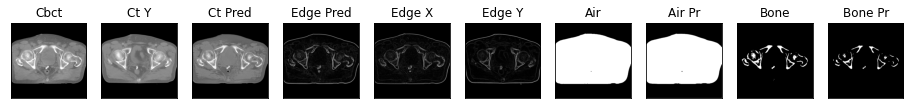

123it [00:47,  2.41it/s]

ssim score = 0.6915421485900879
psnr score = 20.188940048217773
snr score = 12.14155101776123
mae error = 0.050033483654260635
air dice score = 0.9974148304670017
bone dice score = 0.7064959696573435
contour dice score = 0.4154411852359772


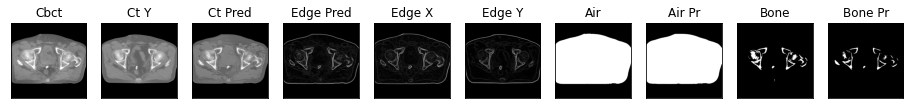

124it [00:48,  2.48it/s]

ssim score = 0.7042944431304932
psnr score = 20.557748794555664
snr score = 12.397930145263672
mae error = 0.047169700264930725
air dice score = 0.9975293248360594
bone dice score = 0.7767386091153867
contour dice score = 0.41828253865242004


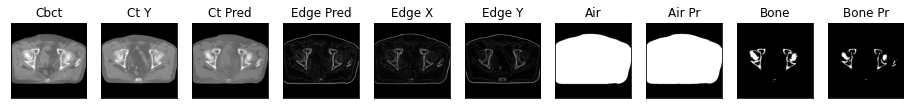

125it [00:48,  2.56it/s]

ssim score = 0.70423424243927
psnr score = 20.802610397338867
snr score = 12.592144966125488
mae error = 0.04479673132300377
air dice score = 0.9976733418219714
bone dice score = 0.8089330024836472
contour dice score = 0.38811513781547546


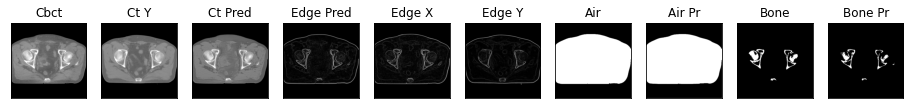

126it [00:48,  2.61it/s]

ssim score = 0.702637255191803
psnr score = 20.59250831604004
snr score = 12.414196968078613
mae error = 0.046636201441287994
air dice score = 0.9978455910107152
bone dice score = 0.8299740323997777
contour dice score = 0.412284791469574


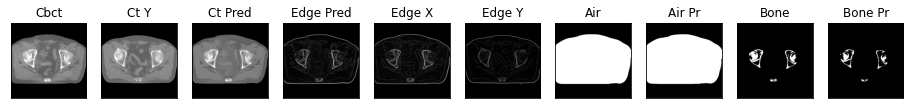

127it [00:49,  2.65it/s]

ssim score = 0.6987104415893555
psnr score = 20.375965118408203
snr score = 12.211132049560547
mae error = 0.0476142056286335
air dice score = 0.997562511662625
bone dice score = 0.849661281919624
contour dice score = 0.397940069437027


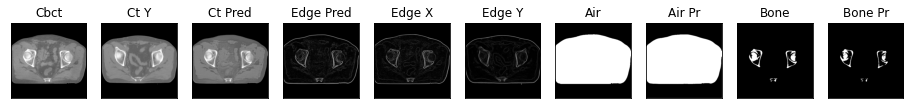

128it [00:49,  2.67it/s]

ssim score = 0.697919487953186
psnr score = 20.179203033447266
snr score = 11.87287712097168
mae error = 0.048516321927309036
air dice score = 0.9975853621370732
bone dice score = 0.8675411522650779
contour dice score = 0.3741143047809601


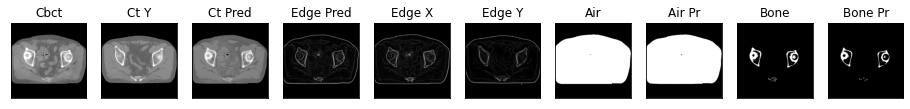

129it [00:50,  2.70it/s]

ssim score = 0.7094826698303223
psnr score = 20.27254867553711
snr score = 11.906915664672852
mae error = 0.047637663781642914
air dice score = 0.9978034402953885
bone dice score = 0.8772557792710327
contour dice score = 0.37363678216934204


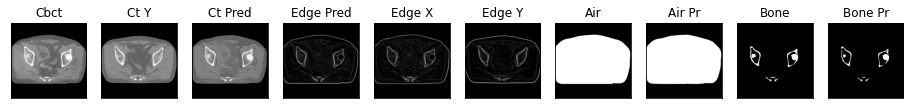

130it [00:50,  2.72it/s]

ssim score = 0.707795262336731
psnr score = 20.568849563598633
snr score = 12.228864669799805
mae error = 0.045235197991132736
air dice score = 0.9980299005484342
bone dice score = 0.8990162617968477
contour dice score = 0.4096728265285492


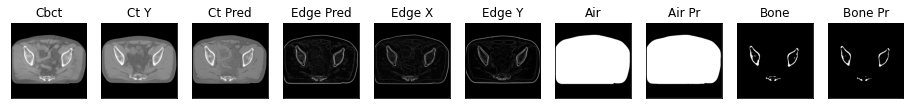

131it [00:50,  2.72it/s]

ssim score = 0.7056568264961243
psnr score = 20.39616584777832
snr score = 12.128993034362793
mae error = 0.045981843024492264
air dice score = 0.9979246573305992
bone dice score = 0.8986486486505509
contour dice score = 0.4049312472343445


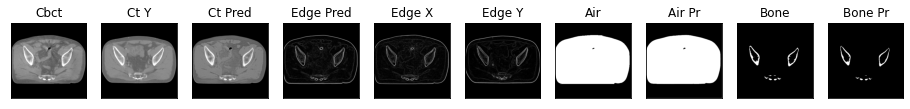

132it [00:51,  2.32it/s]

ssim score = 0.6979942917823792
psnr score = 19.964038848876953
snr score = 11.826095581054688
mae error = 0.04855041205883026
air dice score = 0.9979060473352969
bone dice score = 0.8971078001770884
contour dice score = 0.4420047700405121


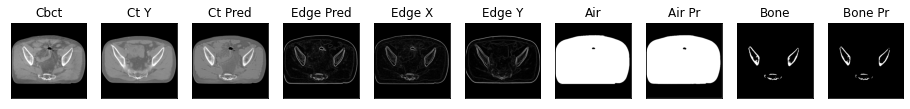

133it [00:51,  2.43it/s]

ssim score = 0.6943596601486206
psnr score = 19.76205062866211
snr score = 11.65806770324707
mae error = 0.04962511360645294
air dice score = 0.9976167262485119
bone dice score = 0.8826960466642466
contour dice score = 0.4282285273075104


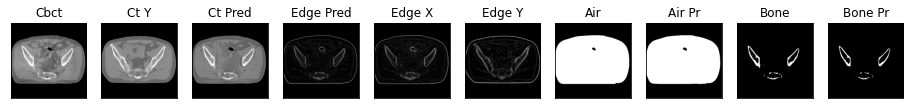

134it [00:52,  2.52it/s]

ssim score = 0.6881495714187622
psnr score = 19.872238159179688
snr score = 11.73846435546875
mae error = 0.049725744873285294
air dice score = 0.9975012071463076
bone dice score = 0.841230936821334
contour dice score = 0.3730120360851288


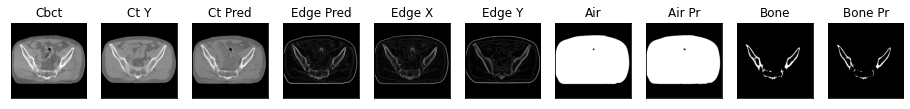

135it [00:52,  2.59it/s]

ssim score = 0.6880320906639099
psnr score = 20.14804458618164
snr score = 11.950894355773926
mae error = 0.048123136162757874
air dice score = 0.9975229385579762
bone dice score = 0.834724052117776
contour dice score = 0.39399805665016174


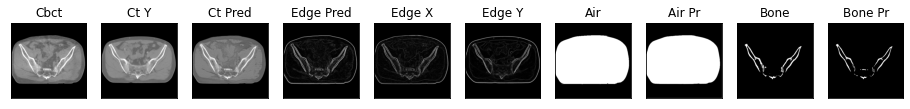

136it [00:52,  2.60it/s]

ssim score = 0.7850425243377686
psnr score = 22.567243576049805
snr score = 14.044632911682129
mae error = 0.03331436589360237
air dice score = 0.9983762261716763
bone dice score = 0.8593667546192696
contour dice score = 0.5717161297798157


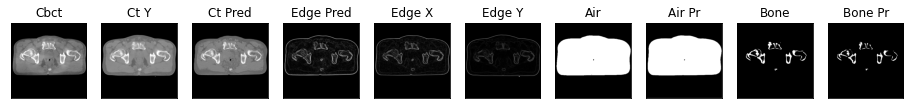

137it [00:53,  2.65it/s]

ssim score = 0.7891339063644409
psnr score = 22.581192016601562
snr score = 14.098594665527344
mae error = 0.0333029069006443
air dice score = 0.9982321656713327
bone dice score = 0.8465039304944628
contour dice score = 0.5570130944252014


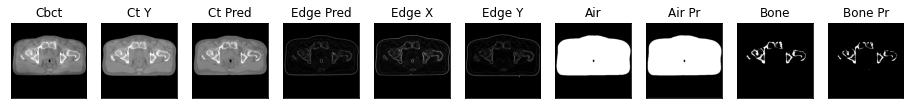

138it [00:53,  2.68it/s]

ssim score = 0.7923460006713867
psnr score = 22.701818466186523
snr score = 14.227008819580078
mae error = 0.033322207629680634
air dice score = 0.9981636916488873
bone dice score = 0.8512878895709223
contour dice score = 0.5937183499336243


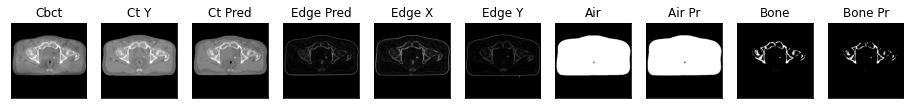

139it [00:53,  2.71it/s]

ssim score = 0.790296196937561
psnr score = 22.70244598388672
snr score = 14.16921615600586
mae error = 0.032540466636419296
air dice score = 0.9979562914895219
bone dice score = 0.8549208903210657
contour dice score = 0.6003047227859497


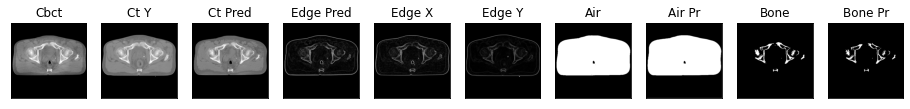

140it [00:54,  2.73it/s]

ssim score = 0.7921488881111145
psnr score = 22.98499298095703
snr score = 14.296136856079102
mae error = 0.029990144073963165
air dice score = 0.9980846925033682
bone dice score = 0.892884824059946
contour dice score = 0.6241713166236877


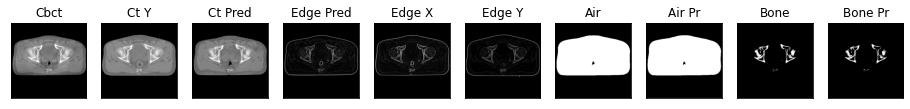

141it [00:54,  2.74it/s]

ssim score = 0.7956274151802063
psnr score = 23.128482818603516
snr score = 14.418825149536133
mae error = 0.02915671467781067
air dice score = 0.9977717925441344
bone dice score = 0.8983625903540586
contour dice score = 0.6196318864822388


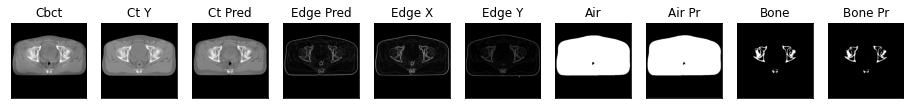

142it [00:55,  2.32it/s]

ssim score = 0.7918335795402527
psnr score = 23.040828704833984
snr score = 14.315542221069336
mae error = 0.029498610645532608
air dice score = 0.9980358070123962
bone dice score = 0.8986135181990379
contour dice score = 0.6416837573051453


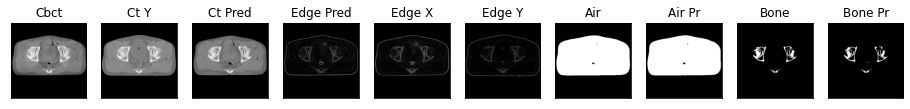

143it [00:55,  2.43it/s]

ssim score = 0.7869593501091003
psnr score = 22.475322723388672
snr score = 13.759401321411133
mae error = 0.03129006177186966
air dice score = 0.9977997051151202
bone dice score = 0.8929672588475559
contour dice score = 0.6123711466789246


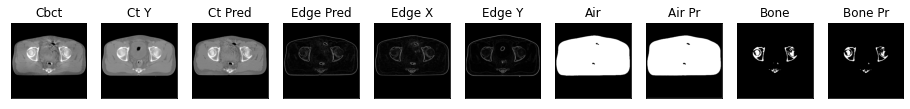

144it [00:55,  2.51it/s]

ssim score = 0.7820935845375061
psnr score = 22.375263214111328
snr score = 13.715123176574707
mae error = 0.03267570212483406
air dice score = 0.9979104206414116
bone dice score = 0.9013440091521112
contour dice score = 0.5338851809501648


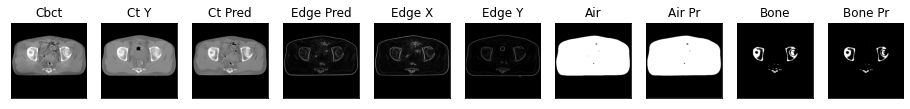

145it [00:56,  2.56it/s]

ssim score = 0.7819743752479553
psnr score = 22.020233154296875
snr score = 13.33816146850586
mae error = 0.03397684544324875
air dice score = 0.9978401399345974
bone dice score = 0.8992202442268763
contour dice score = 0.5464935302734375


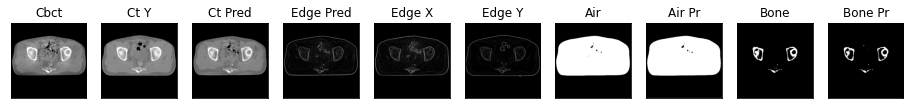

146it [00:56,  2.59it/s]

ssim score = 0.7831218838691711
psnr score = 21.740829467773438
snr score = 12.987983703613281
mae error = 0.03383186087012291
air dice score = 0.9980538362322284
bone dice score = 0.8904241645261821
contour dice score = 0.6137787103652954


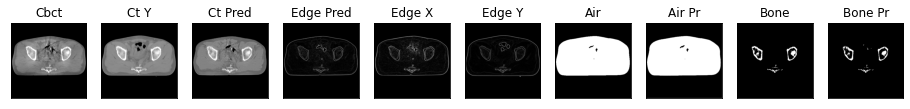

147it [00:57,  2.63it/s]

ssim score = 0.7833684682846069
psnr score = 22.13580322265625
snr score = 13.33906364440918
mae error = 0.03245113417506218
air dice score = 0.9977403200195449
bone dice score = 0.8926301322815215
contour dice score = 0.6341719031333923


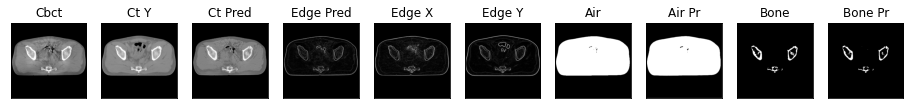

148it [00:57,  2.66it/s]

ssim score = 0.7815216779708862
psnr score = 22.27383804321289
snr score = 13.476003646850586
mae error = 0.03164724260568619
air dice score = 0.9977314530962617
bone dice score = 0.9055657696823405
contour dice score = 0.6557894945144653


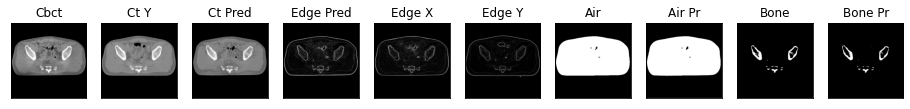

149it [00:57,  2.66it/s]

ssim score = 0.7808513045310974
psnr score = 22.20268440246582
snr score = 13.418206214904785
mae error = 0.03222304955124855
air dice score = 0.9970593669171103
bone dice score = 0.9089175011936271
contour dice score = 0.6694781184196472


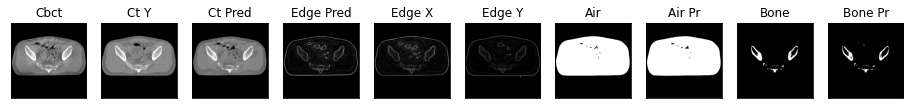

150it [00:58,  2.68it/s]

ssim score = 0.781352162361145
psnr score = 22.1600341796875
snr score = 13.430757522583008
mae error = 0.03287196904420853
air dice score = 0.9972629853562006
bone dice score = 0.879479728796465
contour dice score = 0.6582144498825073


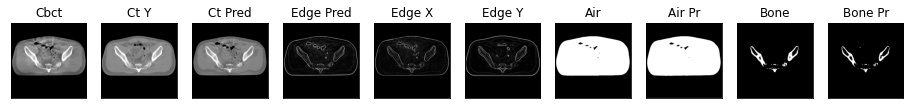

151it [00:58,  2.69it/s]

ssim score = 0.783610463142395
psnr score = 21.800357818603516
snr score = 13.090453147888184
mae error = 0.03400686755776405
air dice score = 0.9967096349630343
bone dice score = 0.8786242183075806
contour dice score = 0.6447855830192566


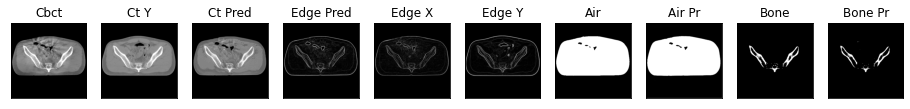

152it [00:59,  2.30it/s]

ssim score = 0.7920307517051697
psnr score = 21.998950958251953
snr score = 13.234309196472168
mae error = 0.03298037499189377
air dice score = 0.9966671048663388
bone dice score = 0.8801703163035254
contour dice score = 0.5884227156639099


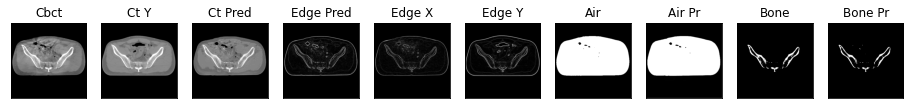

153it [00:59,  2.41it/s]

ssim score = 0.7963312268257141
psnr score = 22.291812896728516
snr score = 13.490818977355957
mae error = 0.03180758282542229
air dice score = 0.997164161805048
bone dice score = 0.8651376146809612
contour dice score = 0.5731056332588196


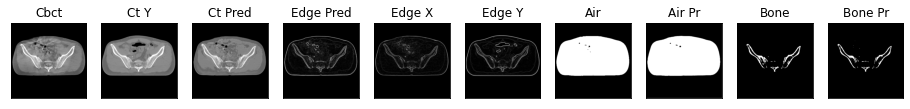

154it [00:59,  2.49it/s]

ssim score = 0.7970235347747803
psnr score = 22.39405632019043
snr score = 13.593132019042969
mae error = 0.031245656311511993
air dice score = 0.997247138880299
bone dice score = 0.8611692479438933
contour dice score = 0.6000000238418579


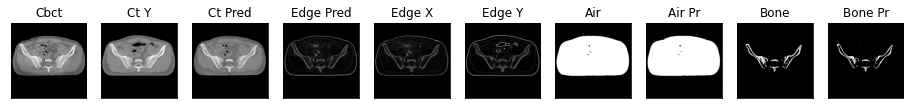

155it [01:00,  2.55it/s]

ssim score = 0.7962896823883057
psnr score = 22.502429962158203
snr score = 13.700082778930664
mae error = 0.031141864135861397
air dice score = 0.9977305294140446
bone dice score = 0.8634447878636774
contour dice score = 0.6691769957542419


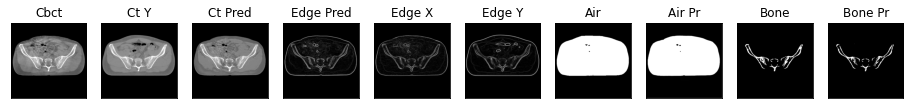

156it [01:00,  2.60it/s]

ssim score = 0.7904309034347534
psnr score = 21.982316970825195
snr score = 13.185009956359863
mae error = 0.032236598432064056
air dice score = 0.9970854997785003
bone dice score = 0.8571831780996728
contour dice score = 0.6251354217529297


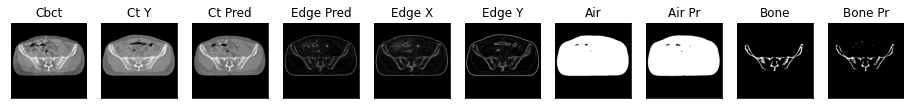

157it [01:01,  2.62it/s]

ssim score = 0.7830913662910461
psnr score = 21.4853572845459
snr score = 12.6707763671875
mae error = 0.033712662756443024
air dice score = 0.995737838006623
bone dice score = 0.8398182334586791
contour dice score = 0.6604904532432556


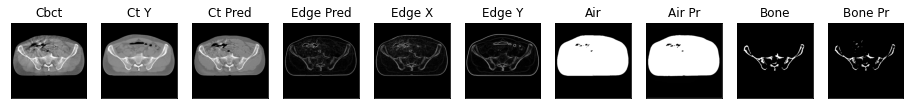

158it [01:01,  2.65it/s]

ssim score = 0.7808098196983337
psnr score = 21.358335494995117
snr score = 12.525130271911621
mae error = 0.034082625061273575
air dice score = 0.9960594451886875
bone dice score = 0.8390989541453594
contour dice score = 0.6560614109039307


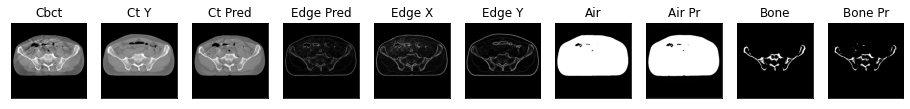

159it [01:01,  2.67it/s]

ssim score = 0.7742178440093994
psnr score = 20.997570037841797
snr score = 12.118427276611328
mae error = 0.03505369648337364
air dice score = 0.9961870169893974
bone dice score = 0.8479358095011268
contour dice score = 0.5993377566337585


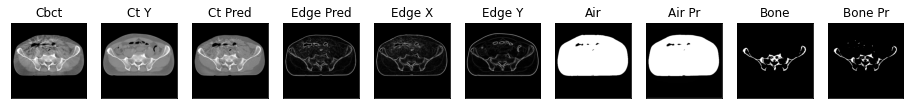

160it [01:02,  2.68it/s]

ssim score = 0.7672017216682434
psnr score = 20.896387100219727
snr score = 11.963447570800781
mae error = 0.0355646051466465
air dice score = 0.9956813857462078
bone dice score = 0.8460767109570559
contour dice score = 0.5893451571464539


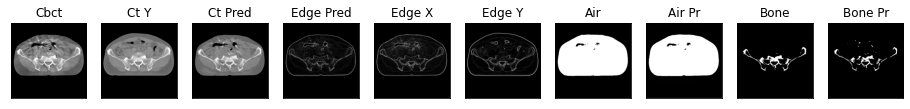

161it [01:02,  2.69it/s]

ssim score = 0.7615223526954651
psnr score = 20.579587936401367
snr score = 11.677111625671387
mae error = 0.03719745948910713
air dice score = 0.9951358857369608
bone dice score = 0.8622474125201793
contour dice score = 0.5868597030639648


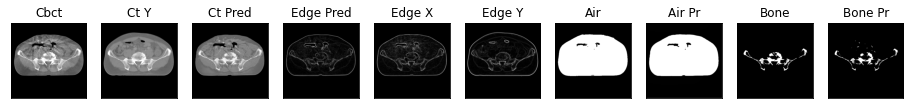

162it [01:03,  2.29it/s]

ssim score = 0.7562391757965088
psnr score = 20.412893295288086
snr score = 11.455190658569336
mae error = 0.0370899923145771
air dice score = 0.9960387534004709
bone dice score = 0.8610291287070315
contour dice score = 0.609131395816803


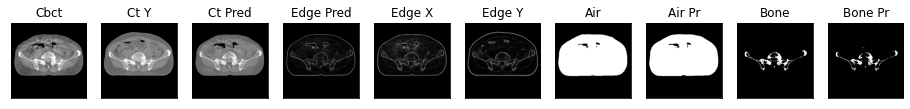

163it [01:03,  2.40it/s]

ssim score = 0.7613714337348938
psnr score = 21.134511947631836
snr score = 12.029279708862305
mae error = 0.033515479415655136
air dice score = 0.9964896081256446
bone dice score = 0.8773849232838241
contour dice score = 0.5439283847808838


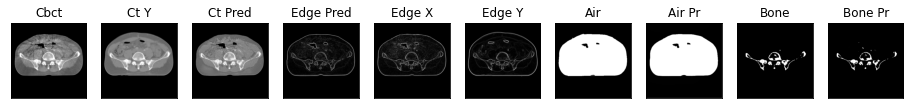

164it [01:03,  2.48it/s]

ssim score = 0.8001534938812256
psnr score = 25.244293212890625
snr score = 15.625205993652344
mae error = 0.021964678540825844
air dice score = 0.9956488391987997
bone dice score = 0.9364161849727689
contour dice score = 0.5470417141914368


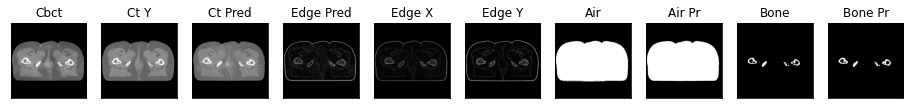

165it [01:04,  2.55it/s]

ssim score = 0.8046184182167053
psnr score = 25.496713638305664
snr score = 15.998638153076172
mae error = 0.021303672343492508
air dice score = 0.9961821712527049
bone dice score = 0.939256572984151
contour dice score = 0.5235032439231873


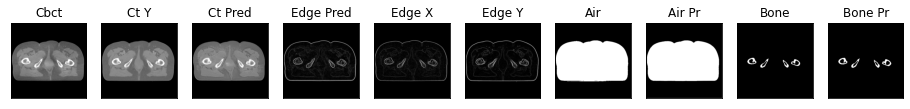

166it [01:04,  2.60it/s]

ssim score = 0.7998262047767639
psnr score = 25.419700622558594
snr score = 16.004541397094727
mae error = 0.02165308967232704
air dice score = 0.9958422229180198
bone dice score = 0.9340749897005753
contour dice score = 0.5031753778457642


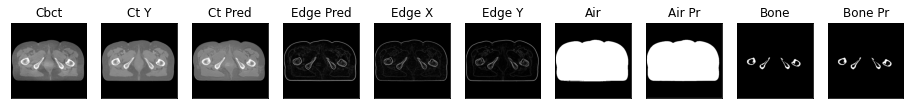

167it [01:04,  2.63it/s]

ssim score = 0.793528139591217
psnr score = 25.24837875366211
snr score = 15.896665573120117
mae error = 0.02229532226920128
air dice score = 0.9959487175770606
bone dice score = 0.9300686329079936
contour dice score = 0.5153733491897583


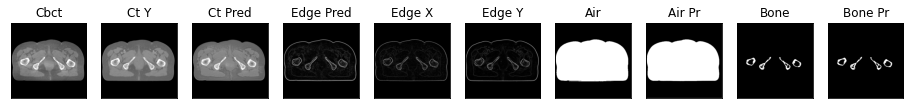

168it [01:05,  2.65it/s]

ssim score = 0.7951326370239258
psnr score = 25.15585708618164
snr score = 15.83260440826416
mae error = 0.022725678980350494
air dice score = 0.995933873076176
bone dice score = 0.9346324180702457
contour dice score = 0.5157480239868164


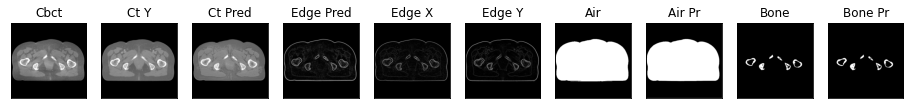

169it [01:05,  2.67it/s]

ssim score = 0.7968677282333374
psnr score = 25.044954299926758
snr score = 15.744656562805176
mae error = 0.022629395127296448
air dice score = 0.9958936676032015
bone dice score = 0.9319992588487679
contour dice score = 0.5114466547966003


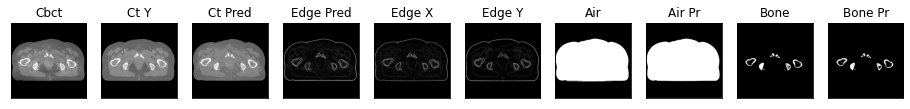

170it [01:06,  2.69it/s]

ssim score = 0.792771577835083
psnr score = 24.959522247314453
snr score = 15.690549850463867
mae error = 0.022987544536590576
air dice score = 0.9958959541726892
bone dice score = 0.9299945165430452
contour dice score = 0.48912519216537476


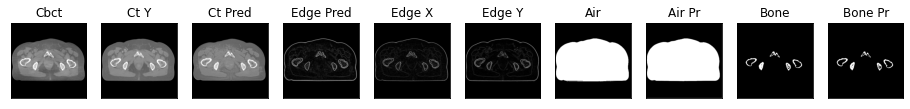

171it [01:06,  2.69it/s]

ssim score = 0.7916237115859985
psnr score = 24.76222801208496
snr score = 15.541622161865234
mae error = 0.02360549196600914
air dice score = 0.995471086006305
bone dice score = 0.9299293862044191
contour dice score = 0.4898918569087982


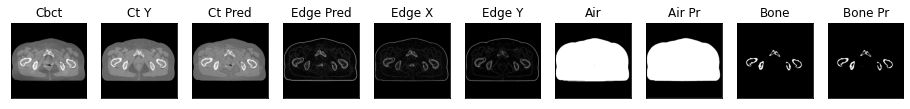

172it [01:06,  2.29it/s]

ssim score = 0.7970719933509827
psnr score = 24.541889190673828
snr score = 15.36402702331543
mae error = 0.023455366492271423
air dice score = 0.9954044117647092
bone dice score = 0.9197404371598406
contour dice score = 0.4634615480899811


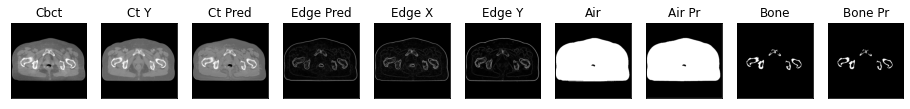

173it [01:07,  2.40it/s]

ssim score = 0.7954958081245422
psnr score = 24.335250854492188
snr score = 15.245089530944824
mae error = 0.02442214824259281
air dice score = 0.9950460928749928
bone dice score = 0.890452876378665
contour dice score = 0.458158016204834


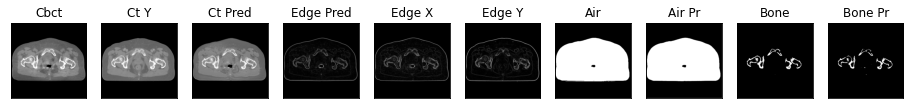

174it [01:07,  2.49it/s]

ssim score = 0.8003880977630615
psnr score = 25.010913848876953
snr score = 16.034029006958008
mae error = 0.023693250492215157
air dice score = 0.9946374946374985
bone dice score = 0.8775722844506698
contour dice score = 0.4090489447116852


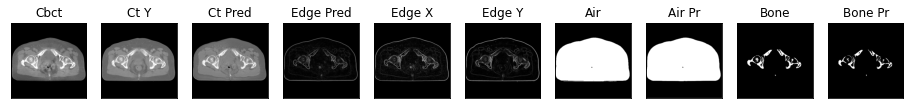

175it [01:08,  2.54it/s]

ssim score = 0.8004140853881836
psnr score = 24.504241943359375
snr score = 15.398802757263184
mae error = 0.023699553683400154
air dice score = 0.99424159516409
bone dice score = 0.9057519057535386
contour dice score = 0.446601927280426


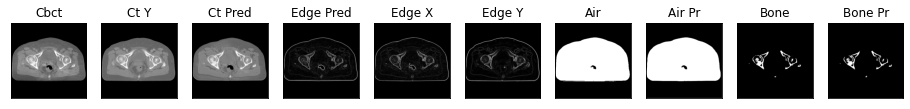

176it [01:08,  2.59it/s]

ssim score = 0.8026539087295532
psnr score = 24.610836029052734
snr score = 15.395975112915039
mae error = 0.023024149239063263
air dice score = 0.9945248813724337
bone dice score = 0.9050216287397964
contour dice score = 0.4616822302341461


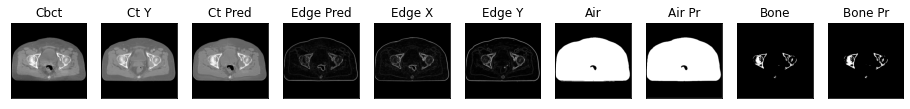

177it [01:08,  2.62it/s]

ssim score = 0.8046255707740784
psnr score = 24.59466552734375
snr score = 15.352676391601562
mae error = 0.023746084421873093
air dice score = 0.9944912230626556
bone dice score = 0.908932004895841
contour dice score = 0.4816513657569885


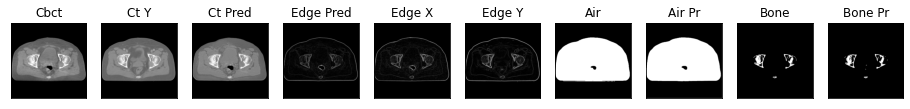

178it [01:09,  2.64it/s]

ssim score = 0.8081529140472412
psnr score = 25.227581024169922
snr score = 15.977588653564453
mae error = 0.023418189957737923
air dice score = 0.9950757736553926
bone dice score = 0.9188267394283965
contour dice score = 0.48108360171318054


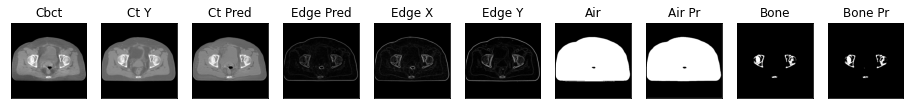

179it [01:09,  2.66it/s]

ssim score = 0.8011457920074463
psnr score = 25.728866577148438
snr score = 16.513103485107422
mae error = 0.022864902392029762
air dice score = 0.995377417386245
bone dice score = 0.9226727959296885
contour dice score = 0.44015079736709595


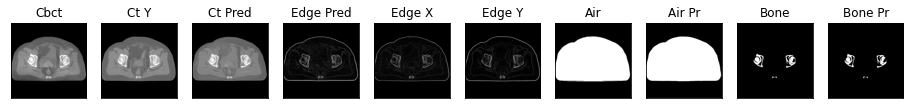

180it [01:09,  2.68it/s]

ssim score = 0.7974259257316589
psnr score = 25.273815155029297
snr score = 16.109540939331055
mae error = 0.02354322373867035
air dice score = 0.996043851950913
bone dice score = 0.93176937056118
contour dice score = 0.4441233277320862


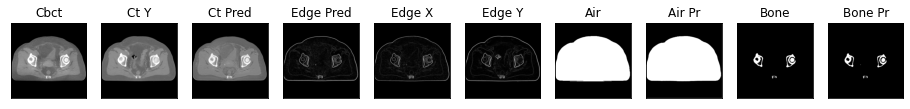

181it [01:10,  2.69it/s]

ssim score = 0.7841482758522034
psnr score = 24.40625762939453
snr score = 15.279542922973633
mae error = 0.02511877566576004
air dice score = 0.9960498328775476
bone dice score = 0.935176871970997
contour dice score = 0.4545454680919647


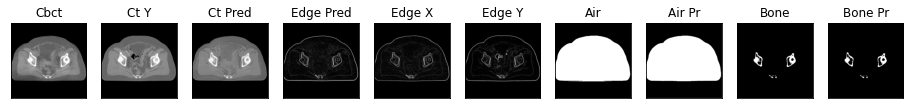

182it [01:10,  2.30it/s]

ssim score = 0.7744773626327515
psnr score = 23.056840896606445
snr score = 13.85768985748291
mae error = 0.02793947607278824
air dice score = 0.9958484051298944
bone dice score = 0.9330047053566434
contour dice score = 0.43890517950057983


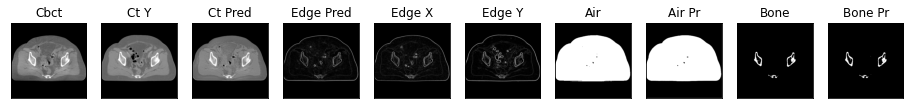

183it [01:11,  2.41it/s]

ssim score = 0.7643164396286011
psnr score = 22.676013946533203
snr score = 13.458871841430664
mae error = 0.029699886217713356
air dice score = 0.9956594915404405
bone dice score = 0.9333333333348399
contour dice score = 0.44565218687057495


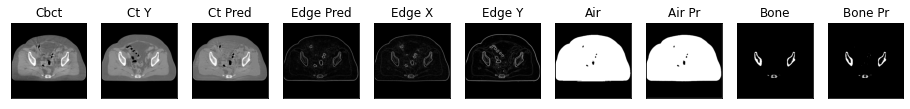

184it [01:11,  2.49it/s]

ssim score = 0.7587175965309143
psnr score = 23.249237060546875
snr score = 14.09700870513916
mae error = 0.02883334271609783
air dice score = 0.9958945942119873
bone dice score = 0.9370112945278668
contour dice score = 0.4290657341480255


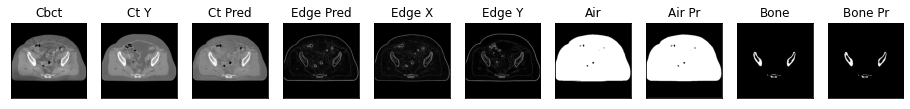

185it [01:12,  2.55it/s]

ssim score = 0.7570590376853943
psnr score = 23.364561080932617
snr score = 14.267423629760742
mae error = 0.02890555001795292
air dice score = 0.9960315869643671
bone dice score = 0.9454001495896522
contour dice score = 0.4350423216819763


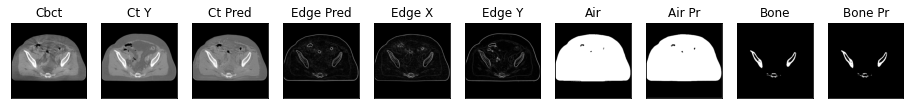

186it [01:12,  2.59it/s]

ssim score = 0.7552551031112671
psnr score = 22.717784881591797
snr score = 13.685079574584961
mae error = 0.03047201968729496
air dice score = 0.9962543346480688
bone dice score = 0.9143319838070554
contour dice score = 0.38877952098846436


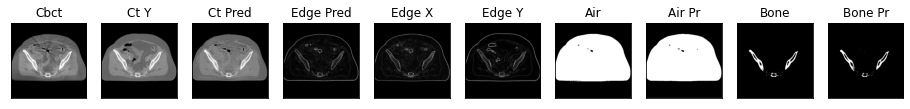

187it [01:12,  2.63it/s]

ssim score = 0.7555572390556335
psnr score = 22.652246475219727
snr score = 13.692402839660645
mae error = 0.03059689886868
air dice score = 0.9959433380157829
bone dice score = 0.9015528418528335
contour dice score = 0.3762962818145752


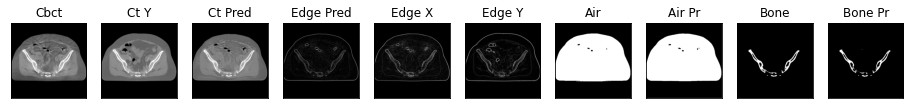

188it [01:13,  2.65it/s]

ssim score = 0.7537248134613037
psnr score = 22.597532272338867
snr score = 13.633395195007324
mae error = 0.0308119747787714
air dice score = 0.995754931961719
bone dice score = 0.8895918059965418
contour dice score = 0.3802541494369507


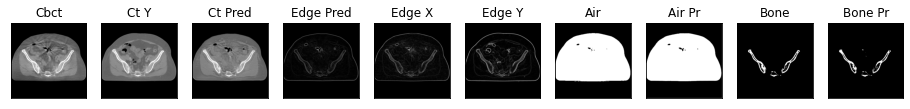

189it [01:13,  2.66it/s]

ssim score = 0.7549349069595337
psnr score = 22.764266967773438
snr score = 13.7779541015625
mae error = 0.030419625341892242
air dice score = 0.9961316278110196
bone dice score = 0.9017595307932293
contour dice score = 0.37706512212753296


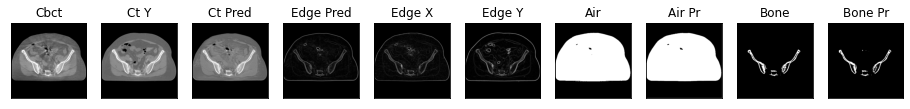

190it [01:13,  2.68it/s]

ssim score = 0.7602427005767822
psnr score = 23.436880111694336
snr score = 14.462203025817871
mae error = 0.029247360303997993
air dice score = 0.9959783380114218
bone dice score = 0.8972989470487213
contour dice score = 0.3627592921257019


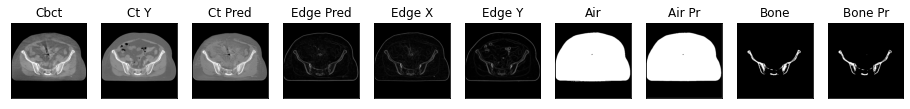

191it [01:14,  2.57it/s]


In [44]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [45]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [46]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [47]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:10, 18.38it/s]


(0.7872544040230556,
 22.87768415880453,
 13.881956220297289,
 0.031206760165423,
 0.9960153143819613,
 0.8843809263185236,
 0.5283122938808971,
 0.518848167539267,
 0.5643979057591623)

In [48]:
# import torchvision.models as models
# models.vgg16(pretrained=True)